<a href="https://colab.research.google.com/github/nancymatijas/OSiRV-Projekt/blob/main/task_z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import os
import sys
import time
import cv2
import numpy as np
from tqdm import tqdm
from glob import glob
import matplotlib.pyplot as plt
from skimage.transform import resize
import shutil
import nibabel as nib
from IPython.display import clear_output
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms.functional as TF
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
import random

In [25]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# **NESTO**

In [26]:
imgs_dir='/content/drive/MyDrive/MICCAI_BraTS2020_TrainingData_comb/'
all_dirs = glob (f'{imgs_dir}/*')
len (all_dirs)
all_dirs.sort()

In [27]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def shuffle_split(all_dirs, val_pct=0.1, test_pct=0.1, seed=42):
    seed_everything(seed)
    n_test = int(len(all_dirs) * test_pct)
    n_val = int(len(all_dirs) * val_pct)
    idx = np.random.permutation(len(all_dirs))
    all_dirs = np.array(all_dirs)[idx]
    test_dirs = all_dirs[:n_test]
    valid_dirs = all_dirs[n_test:n_test + n_val]
    train_dirs = all_dirs[n_test + n_val:]
    return train_dirs, valid_dirs, test_dirs

In [28]:
train_dirs, valid_dirs, test_dirs = shuffle_split(all_dirs)
print(len(train_dirs), len(valid_dirs), len(test_dirs))

297 36 36


In [29]:
class BratsDataset (Dataset):
    def __init__ (self, img_dirs, modality_types, transform = None):
        self.img_dirs = img_dirs
        self.transform = transform
        self.modality_types = modality_types

    def __len__ (self):
        return len (self.img_dirs)

    def __getitem__(self, index):
        imgs_path = self.img_dirs[index]
        patient_id = os.path.basename(imgs_path)
        image = self.concat_imgs(imgs_path)

        mask = np.array(Image.open(f'{imgs_path}/{patient_id}_SEG_combined.jpg'))
        mask = (mask / 255 * 4).round()
        mask = self.preprocess_mask_labels(mask)

        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

         # Select only the first channel from the mask
        mask = mask[..., 0]
        return image.astype(float), mask.astype(float)

    ## Spajanje slika s id-om pacijenta
    def concat_imgs(self, path: str):
      patient_id = os.path.basename(path)
      types = []
      for modality_type in modality_types:
          img = np.array(Image.open(f'{path}/{patient_id}_{modality_type}_combined.jpg'))
          img = self.normalize(img)
          types.append(img)
      #return np.array(types)
      return np.array(types)[..., 0]

    ## Ova metoda pretvara izvornu masku segmentacije u one-hot kodiranu masku s četiri kanala koji predstavljaju različite regije tumora
    ## Cijeli tumor - WT, Tumorska jezgra - TC, Povećanje tumora - ET, Pozadina - BG
    def preprocess_mask_labels(self, mask: np.ndarray):
        mask_WT = np.zeros(mask.shape)
        mask_WT[mask == 2] = 1

        mask_TC = np.zeros(mask.shape)
        mask_TC[mask == 1] = 1

        mask_ET = np.zeros(mask.shape)
        mask_ET[mask == 3] = 1

        mask_BG = np.zeros(mask.shape)
        mask_BG[mask == 0] = 1

        mask = np.stack([mask_WT, mask_TC, mask_ET, mask_BG])
        return mask

    ## Normalizacija ulaznih podataka
    def normalize(self, data: np.ndarray):
        data_min = np.min(data)
        if np.max(data) == 0:
            return data
        if (np.max(data) - data_min) == 0:
            return data / data_min
        return (data - data_min) / (np.max(data) - data_min)

modality_types = ['FLAIR', 'T1', 'T1CE', 'T2']

In [30]:
batch_size = 8

#Datasets
train_ds = BratsDataset(train_dirs, modality_types)
valid_ds = BratsDataset(valid_dirs, modality_types)
test_ds = BratsDataset(test_dirs, modality_types)

#DataLoaders
train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
valid_dl = DataLoader(valid_ds, batch_size = batch_size, shuffle = True)
test_dl = DataLoader(test_ds, batch_size = batch_size, shuffle = True)

print(len(train_dl),len(valid_dl), len(test_dl))

38 5 5


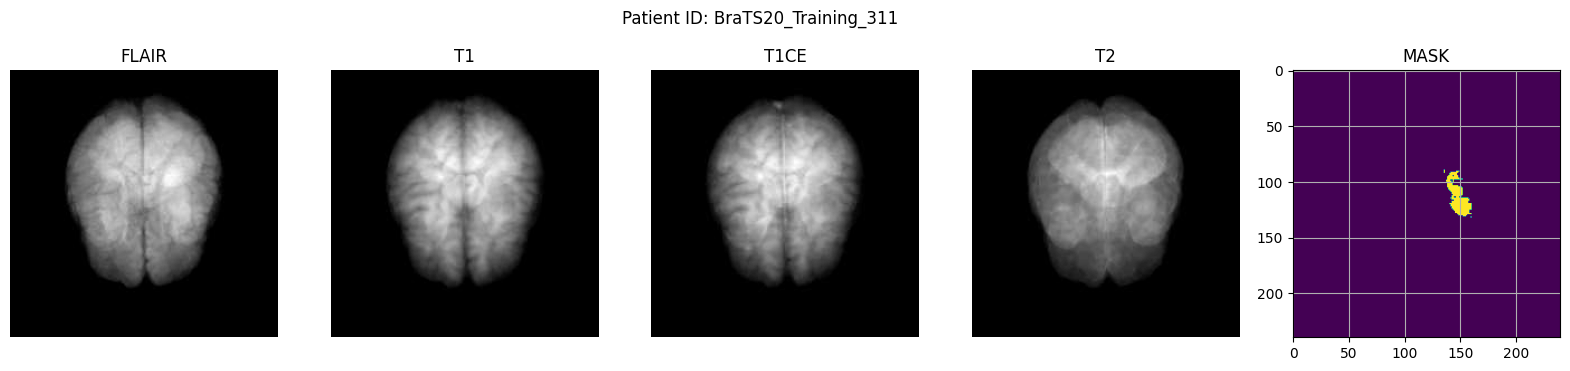

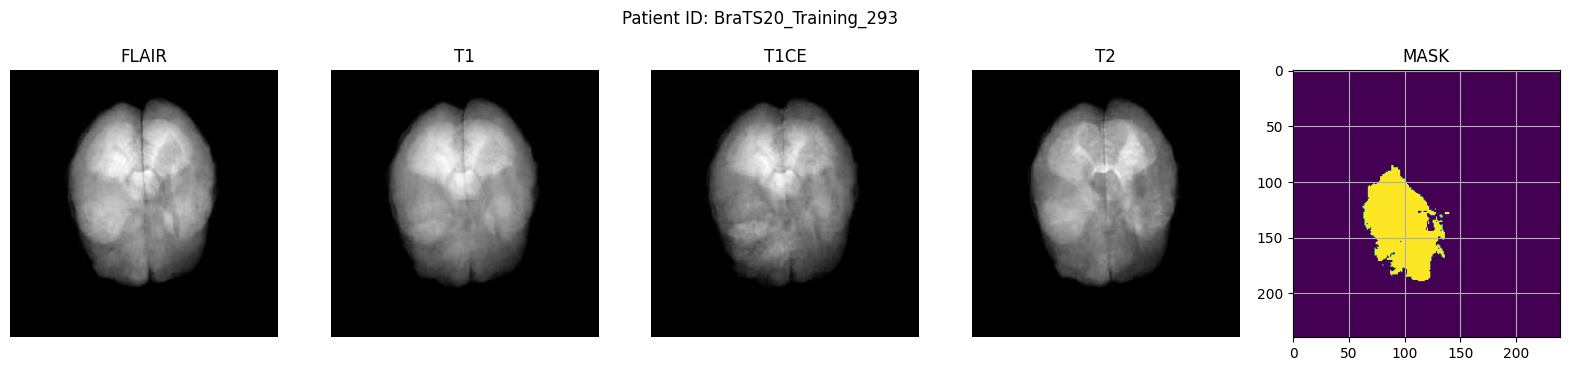

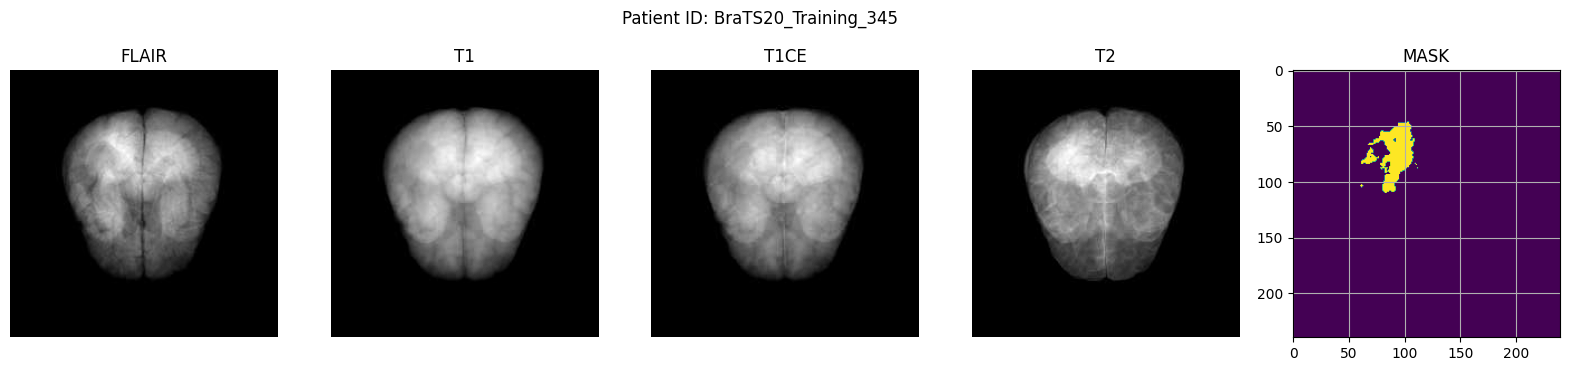

In [31]:
def visualize_samples(dataset, modality_types, num_samples):
    for i in range(num_samples):
        image, mask = dataset[i]

        # Extract patient ID
        patient_id = os.path.basename(dataset.img_dirs[i])

        # Create a single figure with one row and (len(modality_types) + 1) columns
        plt.figure(figsize=(20, 4))

        # Visualize all MRI modalities in the first len(modality_types) columns
        for j in range(len(modality_types)):
            plt.subplot(1, len(modality_types) + 1, j + 1)
            plt.imshow(image[j], cmap='gray')
            plt.axis('off')
            plt.title(f"{modality_types[j]}")

        # Visualize mask in the last column
        plt.subplot(1, len(modality_types) + 1, len(modality_types) + 1)
        plt.imshow(mask[1], cmap='viridis')
        plt.grid()
        plt.title("MASK")

        plt.suptitle(f"Patient ID: {patient_id}")
        plt.show()

# Prikazivanje uzoraka u istom redu
visualize_samples(train_ds, modality_types, num_samples=3)

In [32]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.down5 = Down(1024,2048)

        self.up0 = Up(2048,1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x6 = self.down5(x5)

        x = self.up0(x6,x5)
        x = self.up1(x, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [33]:
## Računa Dice koeficijent za binarnu segmentaciju između predviđenih vjerojatnosti (probabilities) i stvarnih oznaka (truth)
## Dice koeficijent mjeri sličnost između predviđenih i stvarnih područja
def dice_coef_metric(probabilities: torch.Tensor,
                     truth: torch.Tensor,
                     treshold: float = 0.5,
                     eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)
    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = 2.0 * (truth_ * prediction).sum()
        union = truth_.sum() + prediction.sum()
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

## Računa Jaccard koeficijent za binarnu segmentaciju između predviđenih vjerojatnosti i stvarnih oznaka
## Jaccard koeficijent mjeri sličnost između predviđenih i stvarnih područja
def jaccard_coef_metric(probabilities: torch.Tensor,
               truth: torch.Tensor,
               treshold: float = 0.5,
               eps: float = 1e-9) -> np.ndarray:
    scores = []
    num = probabilities.shape[0]
    predictions = (probabilities >= treshold).float()
    assert(predictions.shape == truth.shape)

    for i in range(num):
        prediction = predictions[i]
        truth_ = truth[i]
        intersection = (prediction * truth_).sum()
        union = (prediction.sum() + truth_.sum()) - intersection + eps
        if truth_.sum() == 0 and prediction.sum() == 0:
            scores.append(1.0)
        else:
            scores.append((intersection + eps) / union)
    return np.mean(scores)

In [34]:
## Klasa koja služi za praćenje i ažuriranje Dice i Jaccard koeficijenata tijekom evaluacije modela
class Meter:
    def __init__(self, treshold: float = 0.5):
        self.threshold: float = treshold
        self.dice_scores: list = []
        self.iou_scores: list = []

    def update(self, logits: torch.Tensor, targets: torch.Tensor):
        probs = torch.sigmoid(logits)
        dice = dice_coef_metric(probs, targets, self.threshold)
        iou = jaccard_coef_metric(probs, targets, self.threshold)

        self.dice_scores.append(dice)
        self.iou_scores.append(iou)

    def get_metrics(self) -> np.ndarray:
        dice = np.mean(self.dice_scores)
        iou = np.mean(self.iou_scores)
        return dice, iou

In [35]:
def bce_dice_loss(input, target, alpha, beta, smooth=1):
    # BCE loss
    bce_loss = F.binary_cross_entropy_with_logits(input, target)

    # Dice loss
    input = torch.sigmoid(input)
    input_flat = input.view(-1)
    target_flat = target.view(-1)
    intersection = (input_flat * target_flat).sum()
    dice_loss = 1 - (2 * intersection + smooth) / (input_flat.sum() + target_flat.sum() + smooth)

    # Combined loss
    loss = alpha * bce_loss + beta * dice_loss

    return loss

In [36]:
class Trainer:
    def __init__(self,
                 net: nn.Module,
                 train_dl: DataLoader,
                 val_dl: DataLoader,
                 lr: float,
                 accumulation_steps: int,
                 batch_size: int,
                 num_epochs: int,
                 display_plot: bool = True,

                ):

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print("device:", self.device)
        self.display_plot = display_plot
        self.net = net
        self.net = self.net.to(self.device)
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr, betas=(0.9,0.999))
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=2, verbose=True)
        self.accumulation_steps = accumulation_steps // batch_size
        self.phases = ["train", "val"]
        self.num_epochs = num_epochs
        self.dataloaders = {
            "train": train_dl,
            "val"  : val_dl
        }
        self.best_loss = float("inf")
        self.losses = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        self.jaccard_scores = {phase: [] for phase in self.phases}

    def _compute_loss_and_outputs(self, images: torch.Tensor, targets: torch.Tensor):
        images = images.to(self.device)
        targets = targets.to(self.device)
        logits = self.net(images.float())
        loss = bce_dice_loss(logits, targets, alpha=0.5, beta=0.5)
        return loss, logits

    def _do_epoch(self, epoch: int, phase: str):
        self.net.train() if phase == "train" else self.net.eval()
        meter = Meter()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)
        running_loss = 0.0
        self.optimizer.zero_grad()

        for itr, (images, targets) in enumerate(tqdm(dataloader, desc=f"{phase} epoch {epoch + 1}/{self.num_epochs}")):
            loss, logits = self._compute_loss_and_outputs(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            meter.update(logits.detach().cpu(), targets.detach().cpu())

        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_dice, epoch_iou = meter.get_metrics()

        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(epoch_dice)
        self.jaccard_scores[phase].append(epoch_iou)

        print(f"Loss: {epoch_loss:.4f} | Dice: {epoch_dice:.4f} | IoU: {epoch_iou:.4f}")
        return epoch_loss

    ## Pokretanje treniranja kroz sve epohe
    def run(self):
        for epoch in range(self.num_epochs):
            self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if self.display_plot:
                self._plot_train_history()

            if val_loss < self.best_loss:
                self.best_loss = val_loss
                torch.save(self.net.state_dict(), "best_model.pth")
            print()
        self._save_train_history()

    ## Prikaz grafa gubitaka, Dice i Jaccard koeficijenata tijekom treninga i validacije
    def _plot_train_history(self):
        data = [self.losses, self.dice_scores, self.jaccard_scores]
        colors = ['pink', 'violet']
        labels = [
            f"Train Loss: {self.losses['train'][-1]:.4f} \nValidation Loss: {self.losses['val'][-1]:.4f}",
            f"Train Dice: {self.dice_scores['train'][-1]:.4f} \nValidation Dice: {self.dice_scores['val'][-1]:.4f}",
            f"Train Jaccard: {self.jaccard_scores['train'][-1]:.4f} \nValidation Jaccard: {self.jaccard_scores['val'][-1]:.4f}"
        ]

        with plt.style.context("seaborn-dark-palette"):
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))

            for i, ax in enumerate(axes):
                ax.plot(data[i]['val'], c=colors[0], label="Validation")
                ax.plot(data[i]['train'], c=colors[1], label="Training")
                ax.set_title(labels[i])
                ax.legend(loc="upper right")

            plt.tight_layout()
            plt.show()

    ## Spremanje težine modela i rezultate treniranja
    def _save_train_history(self):
        torch.save(self.net.state_dict(),
                   f"last_epoch_model.pth")

        logs_ = [self.losses, self.dice_scores, self.jaccard_scores]
        log_names_ = ["_loss", "_dice", "_jaccard"]
        logs = [logs_[i][key] for i in list(range(len(logs_)))
                         for key in logs_[i]]
        log_names = [key+log_names_[i]
                     for i in list(range(len(logs_)))
                     for key in logs_[i]
                    ]
        pd.DataFrame(
            dict(zip(log_names, logs))
        ).to_csv("train_log.csv", index=False)

In [37]:
device = torch.device ('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=4, n_classes=4).to(device)

In [38]:
trainer = Trainer(net = model,
                  train_dl = train_dl,
                  val_dl = valid_dl,
                  lr = 1e-5,
                  accumulation_steps = batch_size,
                  batch_size = batch_size,
                  num_epochs = 50,
                 )

device: cuda


train epoch 1/50: 100%|██████████| 38/38 [00:28<00:00,  1.31it/s]


Loss: 0.6767 | Dice: 0.4177 | IoU: 0.2682


val epoch 1/50: 100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


Loss: 0.6635 | Dice: 0.5645 | IoU: 0.3948


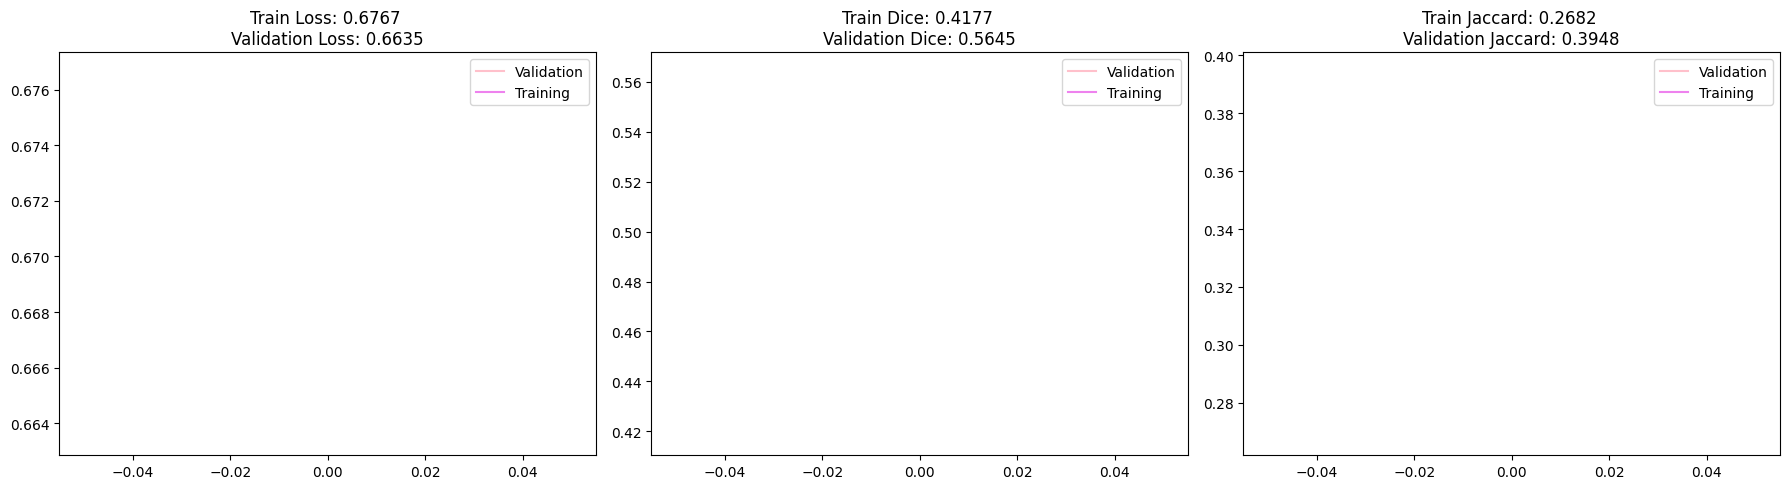

train epoch 2/50: 100%|██████████| 38/38 [00:28<00:00,  1.31it/s]


Loss: 0.6409 | Dice: 0.5692 | IoU: 0.3990


val epoch 2/50: 100%|██████████| 5/5 [00:01<00:00,  2.94it/s]


Loss: 0.6218 | Dice: 0.6046 | IoU: 0.4342


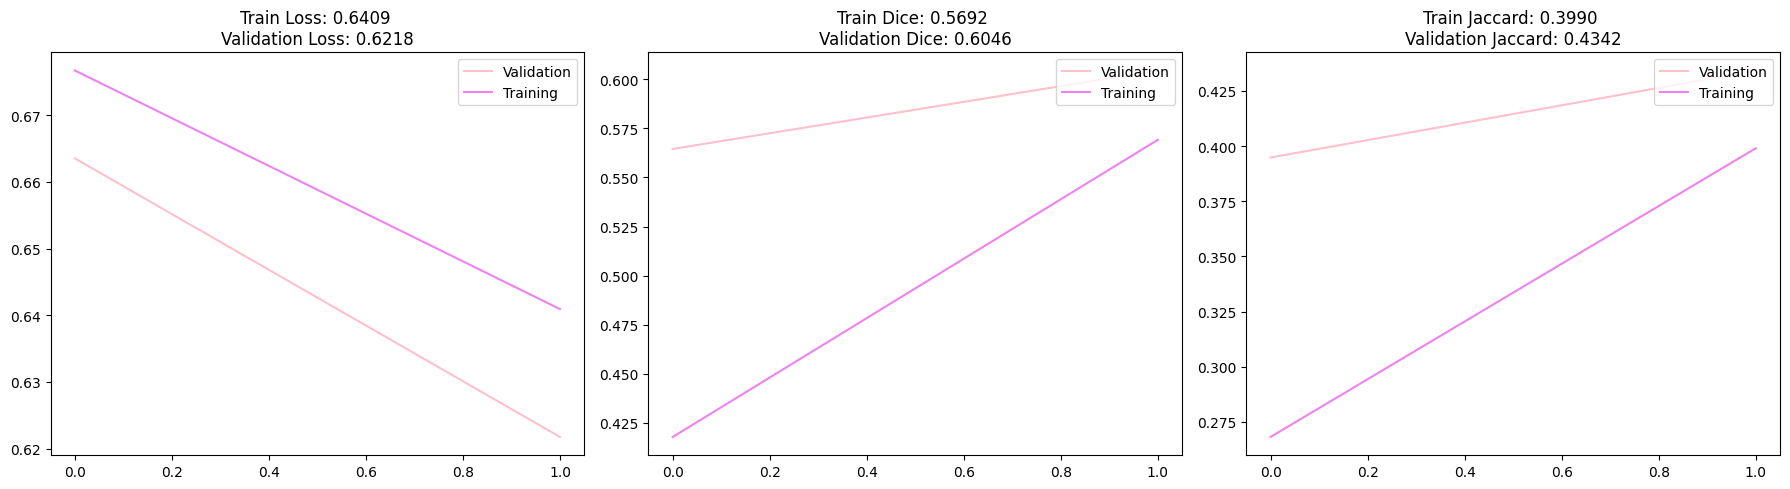

train epoch 3/50: 100%|██████████| 38/38 [00:28<00:00,  1.33it/s]


Loss: 0.6076 | Dice: 0.6331 | IoU: 0.4644


val epoch 3/50: 100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


Loss: 0.5889 | Dice: 0.6912 | IoU: 0.5286


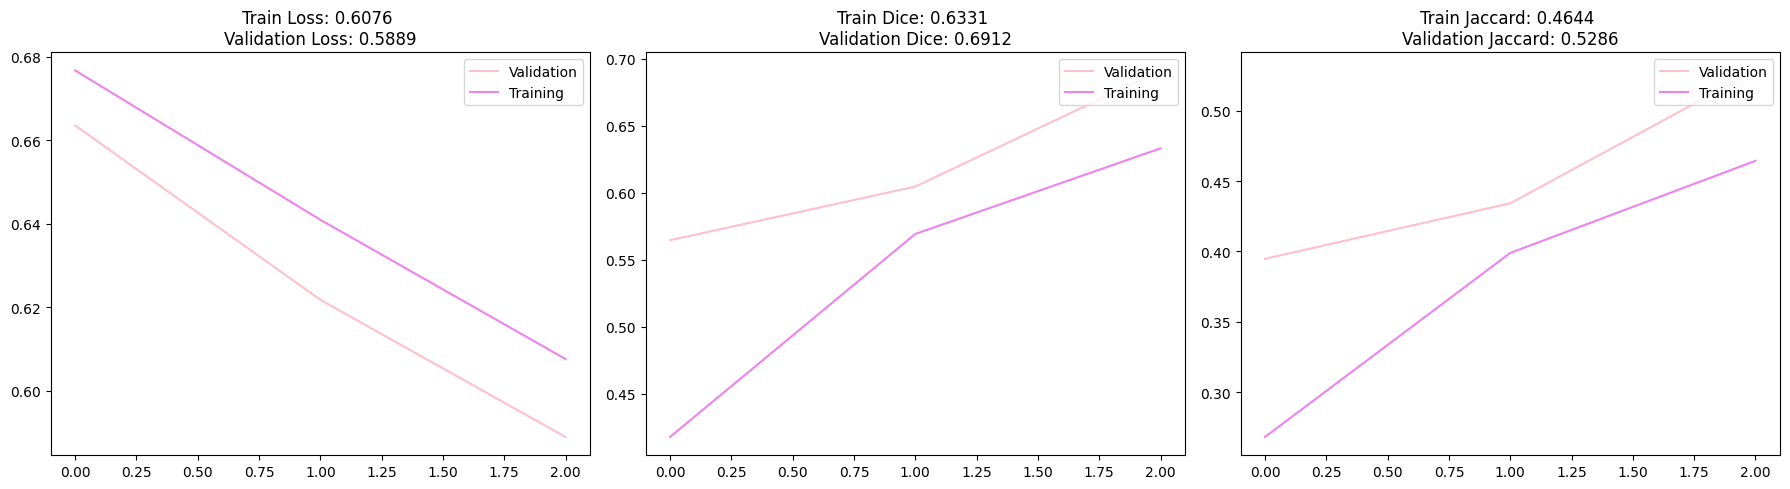

train epoch 4/50: 100%|██████████| 38/38 [00:28<00:00,  1.33it/s]


Loss: 0.5813 | Dice: 0.7328 | IoU: 0.5805


val epoch 4/50: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


Loss: 0.5724 | Dice: 0.7874 | IoU: 0.6498


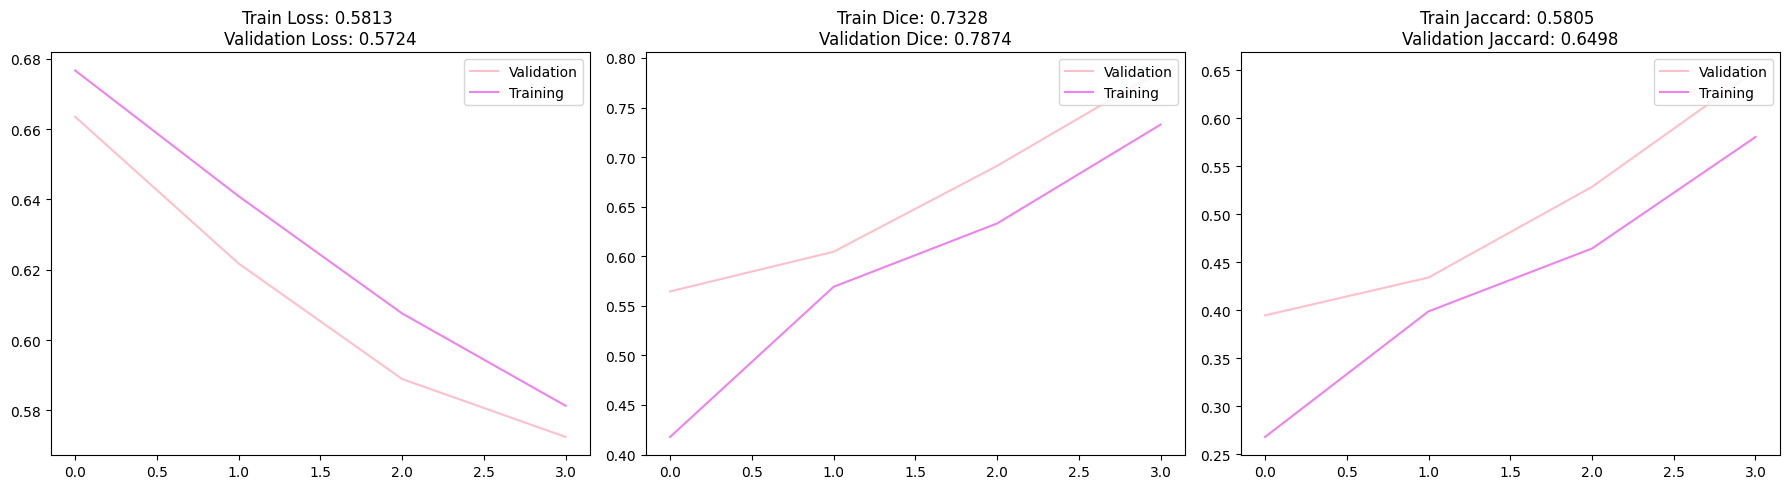

train epoch 5/50: 100%|██████████| 38/38 [00:29<00:00,  1.30it/s]


Loss: 0.5650 | Dice: 0.8178 | IoU: 0.6938


val epoch 5/50: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Loss: 0.5565 | Dice: 0.8574 | IoU: 0.7506


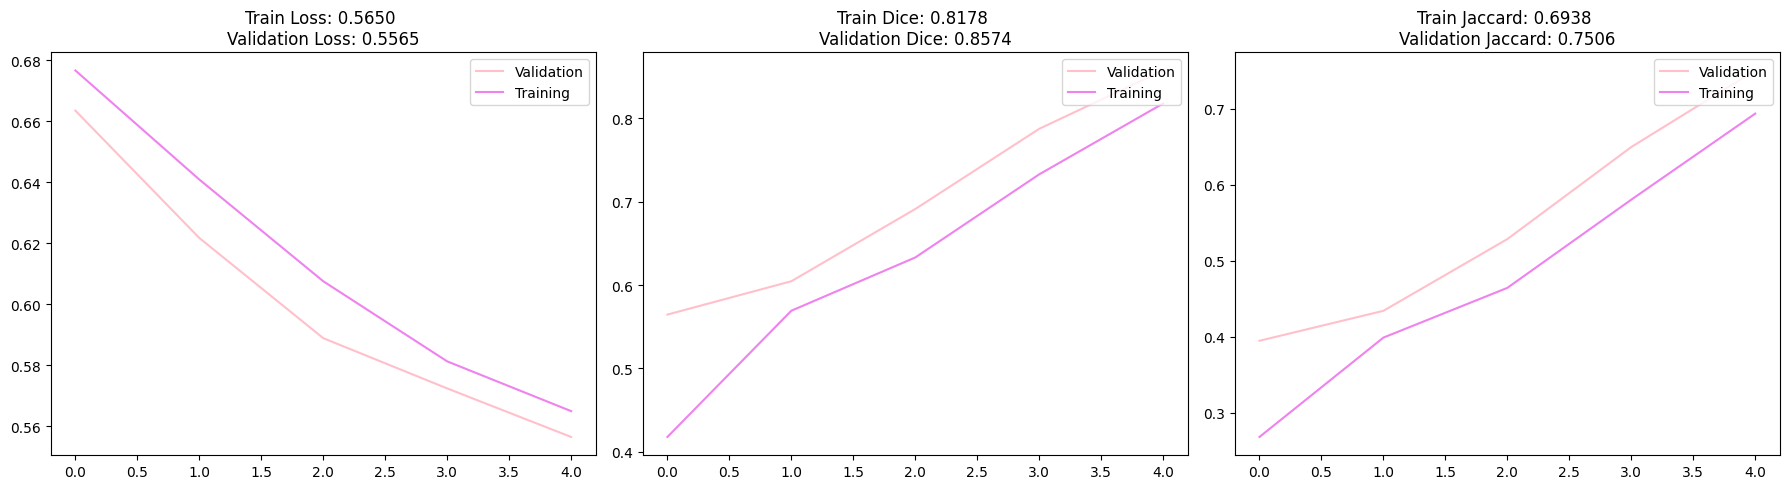

train epoch 6/50: 100%|██████████| 38/38 [00:28<00:00,  1.34it/s]


Loss: 0.5534 | Dice: 0.8609 | IoU: 0.7564


val epoch 6/50: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]


Loss: 0.5449 | Dice: 0.8741 | IoU: 0.7766


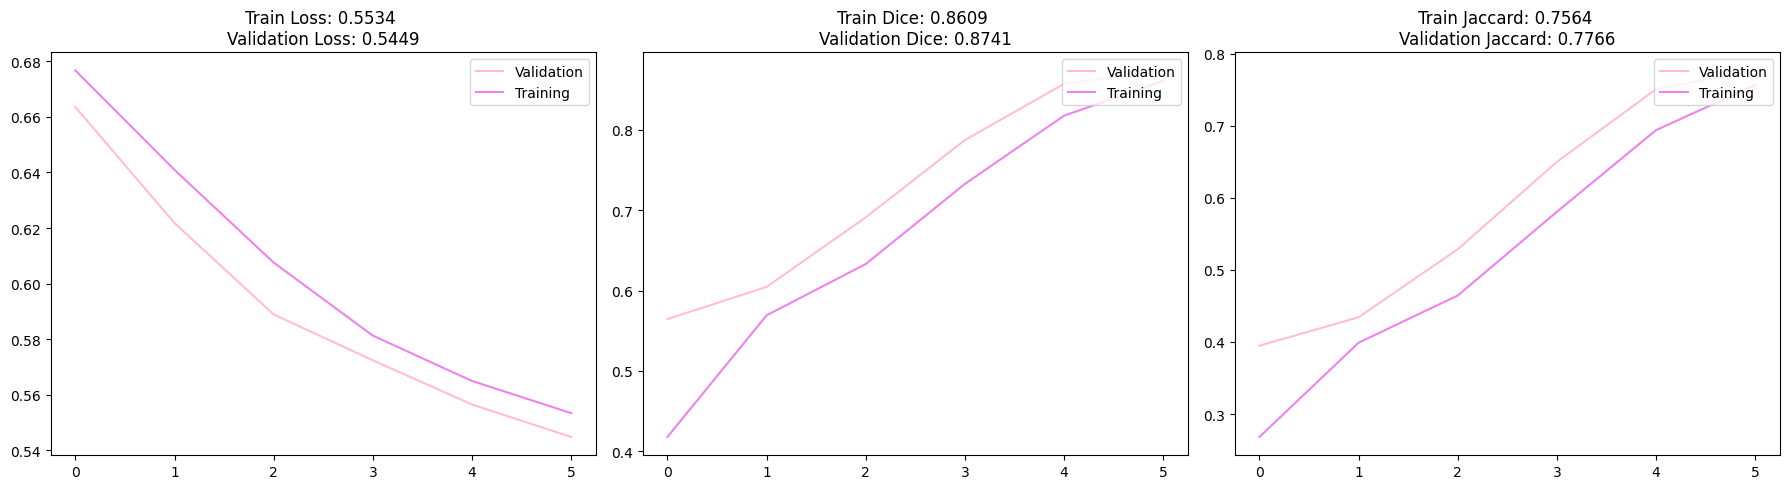

train epoch 7/50: 100%|██████████| 38/38 [00:28<00:00,  1.33it/s]


Loss: 0.5455 | Dice: 0.8717 | IoU: 0.7732


val epoch 7/50: 100%|██████████| 5/5 [00:01<00:00,  2.86it/s]


Loss: 0.5398 | Dice: 0.8773 | IoU: 0.7816


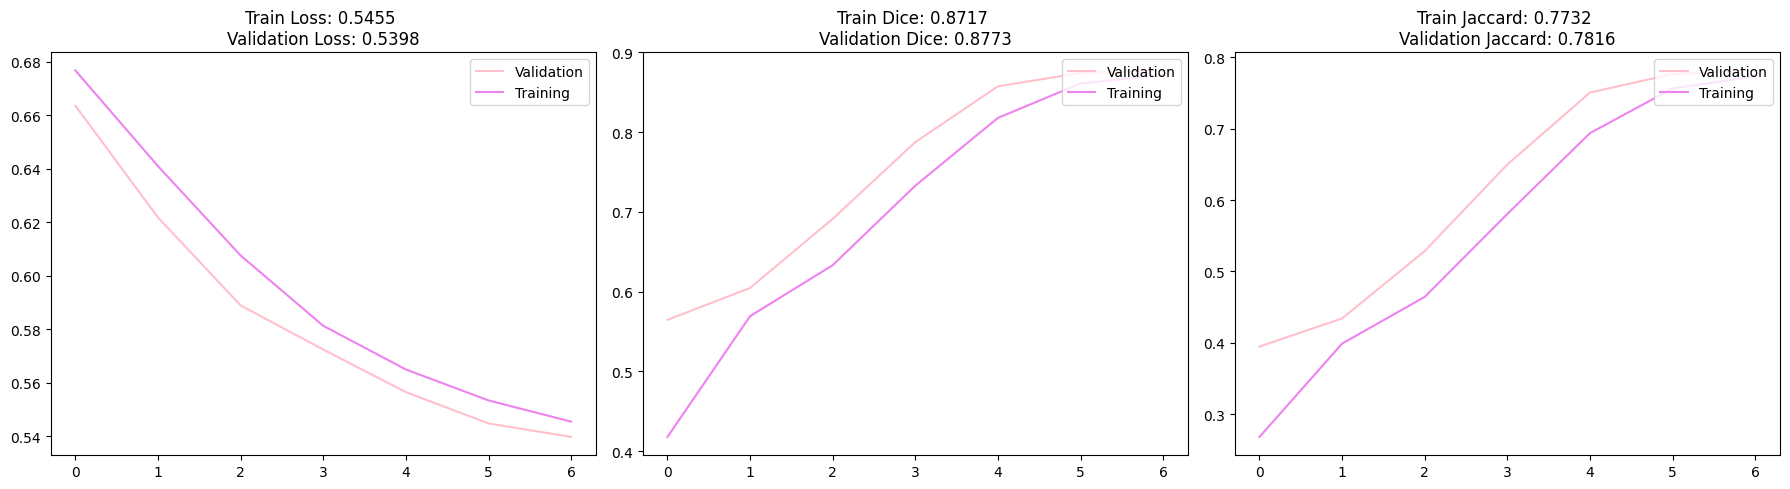

train epoch 8/50: 100%|██████████| 38/38 [00:29<00:00,  1.31it/s]


Loss: 0.5376 | Dice: 0.8807 | IoU: 0.7870


val epoch 8/50: 100%|██████████| 5/5 [00:01<00:00,  2.90it/s]


Loss: 0.5349 | Dice: 0.8807 | IoU: 0.7871


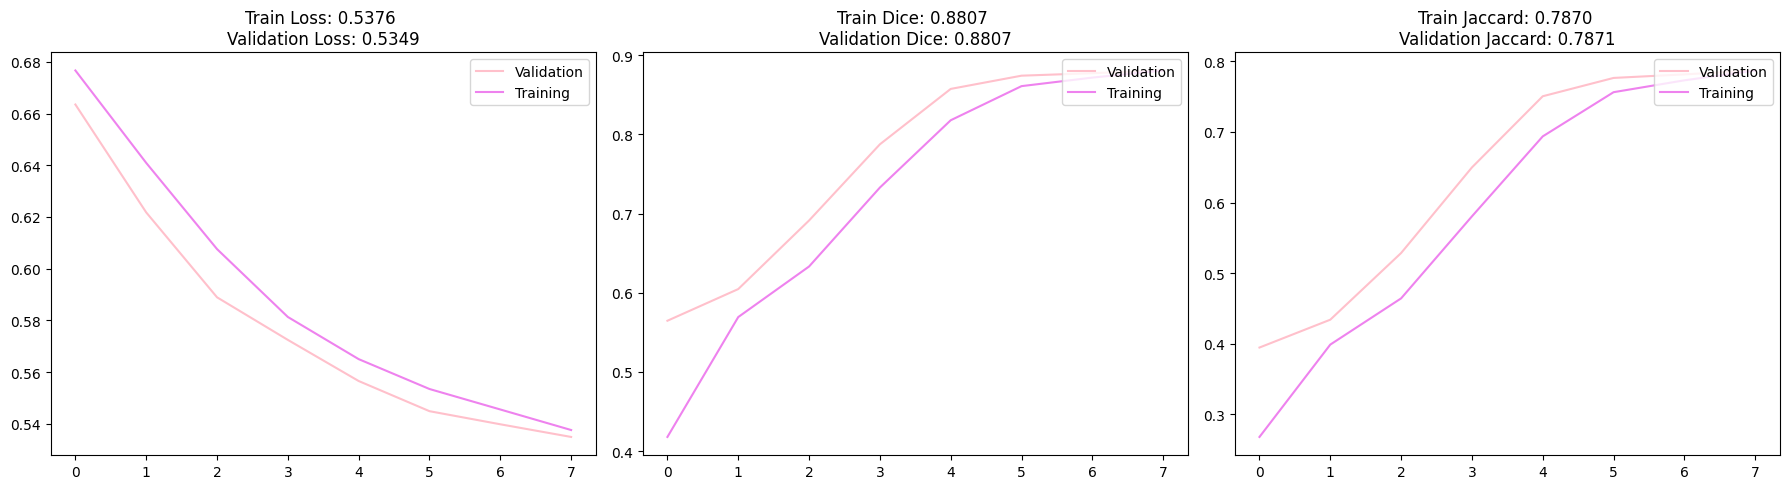

train epoch 9/50: 100%|██████████| 38/38 [00:29<00:00,  1.30it/s]


Loss: 0.5329 | Dice: 0.8842 | IoU: 0.7926


val epoch 9/50: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]


Loss: 0.5291 | Dice: 0.8879 | IoU: 0.7985


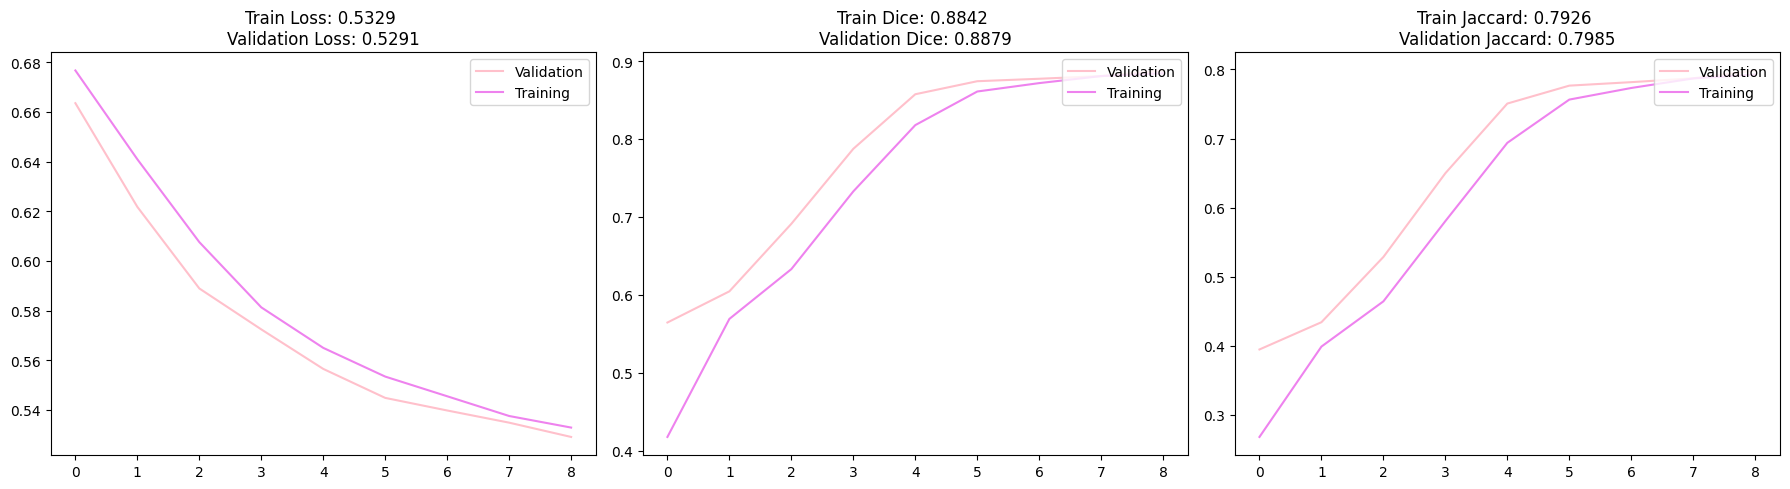

train epoch 10/50: 100%|██████████| 38/38 [00:28<00:00,  1.32it/s]


Loss: 0.5284 | Dice: 0.8877 | IoU: 0.7982


val epoch 10/50: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


Loss: 0.5254 | Dice: 0.8876 | IoU: 0.7982


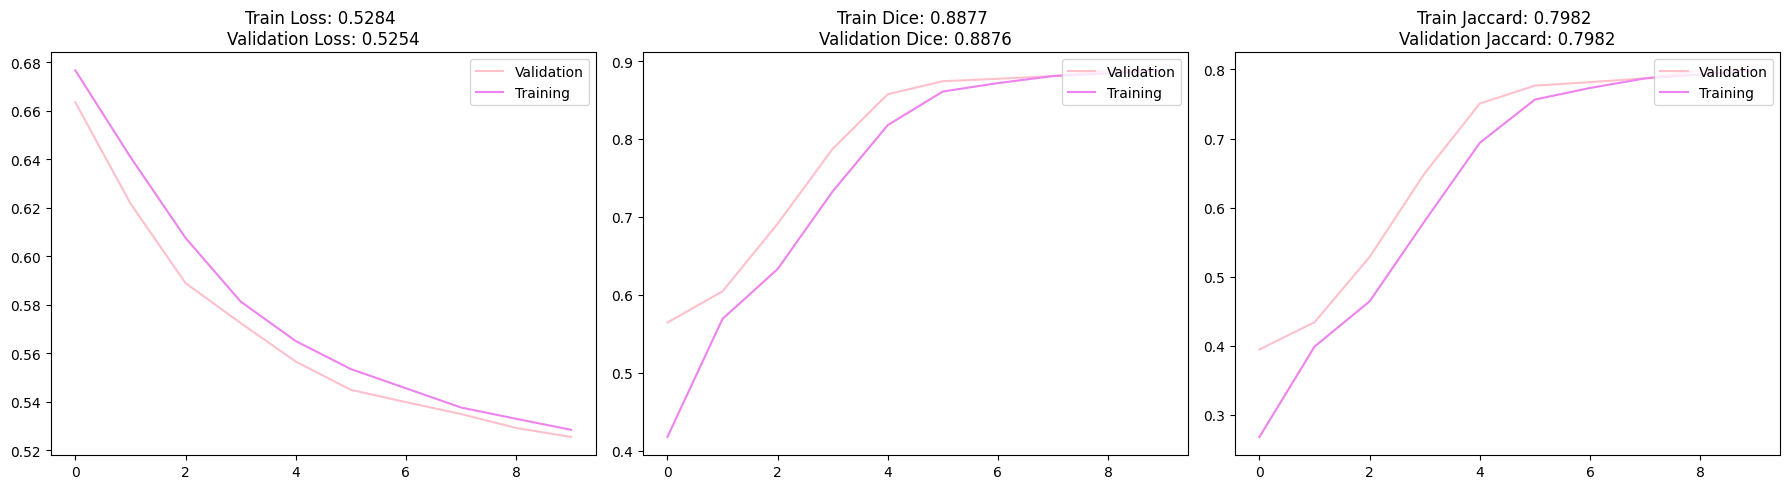

train epoch 11/50: 100%|██████████| 38/38 [00:29<00:00,  1.31it/s]


Loss: 0.5244 | Dice: 0.8904 | IoU: 0.8027


val epoch 11/50: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Loss: 0.5220 | Dice: 0.8907 | IoU: 0.8031


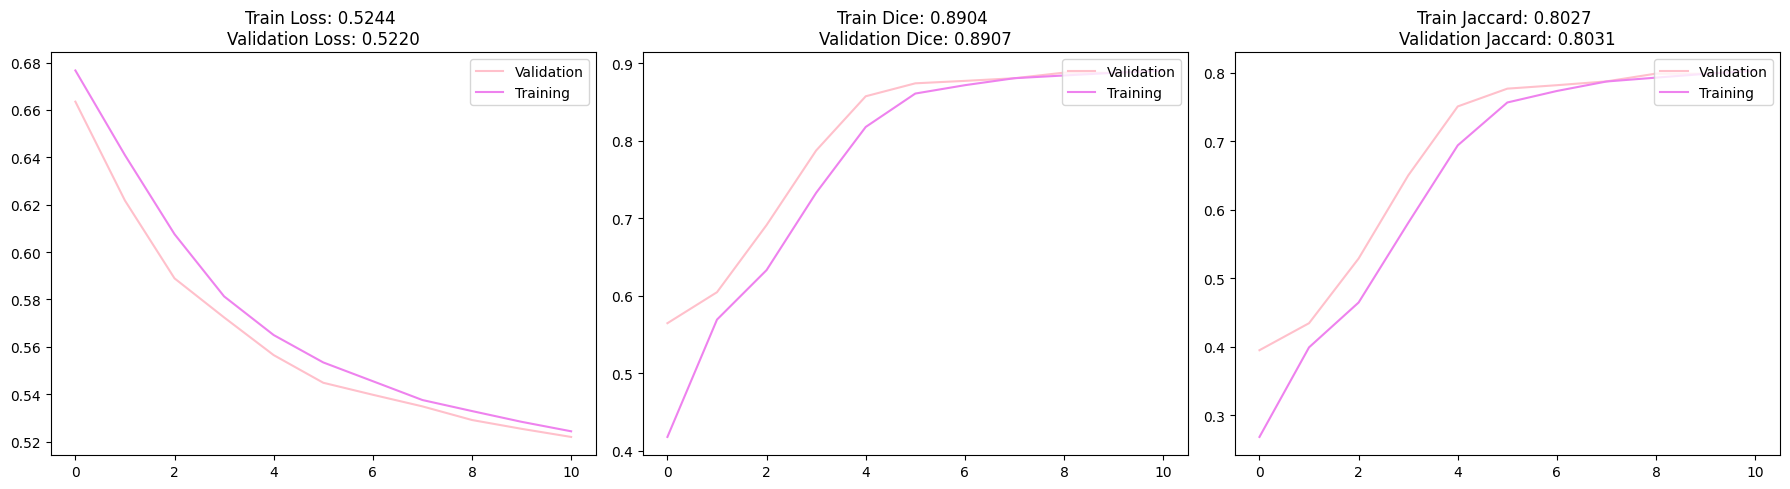

train epoch 12/50: 100%|██████████| 38/38 [00:29<00:00,  1.30it/s]


Loss: 0.5208 | Dice: 0.8959 | IoU: 0.8118


val epoch 12/50: 100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


Loss: 0.5177 | Dice: 0.9100 | IoU: 0.8349


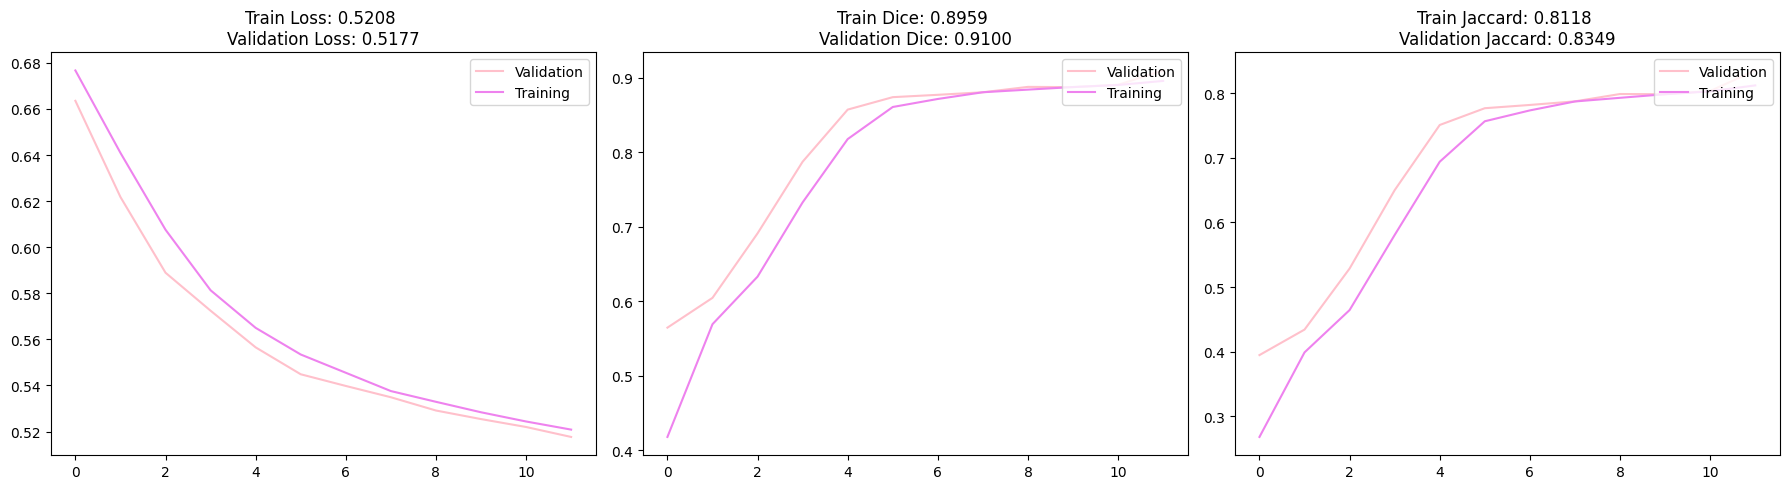

train epoch 13/50: 100%|██████████| 38/38 [00:28<00:00,  1.34it/s]


Loss: 0.5183 | Dice: 0.9364 | IoU: 0.8815


val epoch 13/50: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]


Loss: 0.5155 | Dice: 0.9560 | IoU: 0.9159


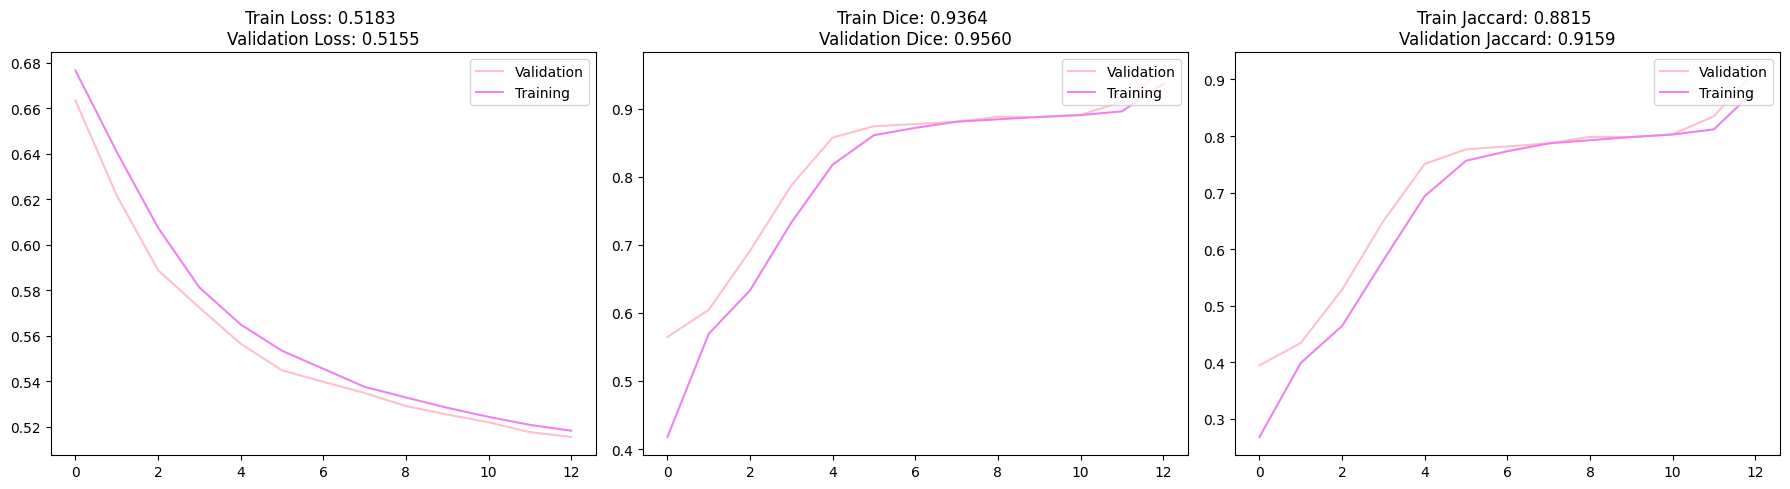

train epoch 14/50: 100%|██████████| 38/38 [00:28<00:00,  1.32it/s]


Loss: 0.5146 | Dice: 0.9557 | IoU: 0.9156


val epoch 14/50: 100%|██████████| 5/5 [00:01<00:00,  2.84it/s]


Loss: 0.5110 | Dice: 0.9600 | IoU: 0.9232


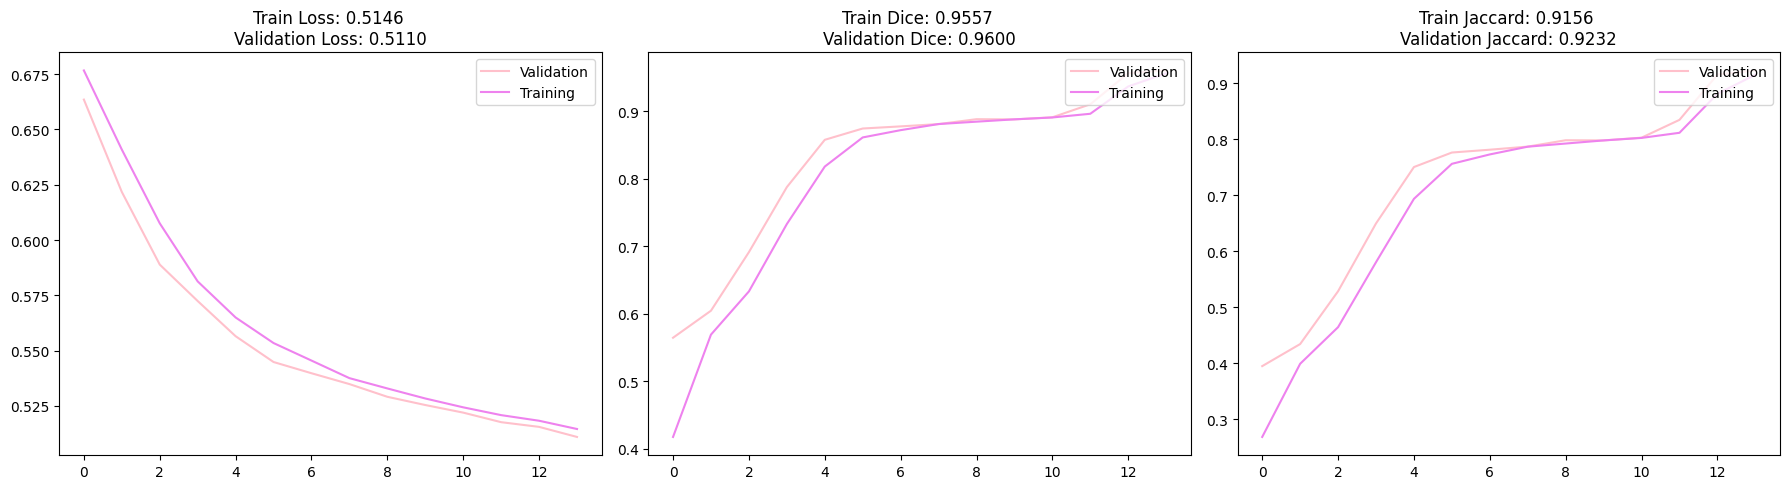

train epoch 15/50: 100%|██████████| 38/38 [00:29<00:00,  1.31it/s]


Loss: 0.5112 | Dice: 0.9604 | IoU: 0.9240


val epoch 15/50: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


Loss: 0.5092 | Dice: 0.9627 | IoU: 0.9283


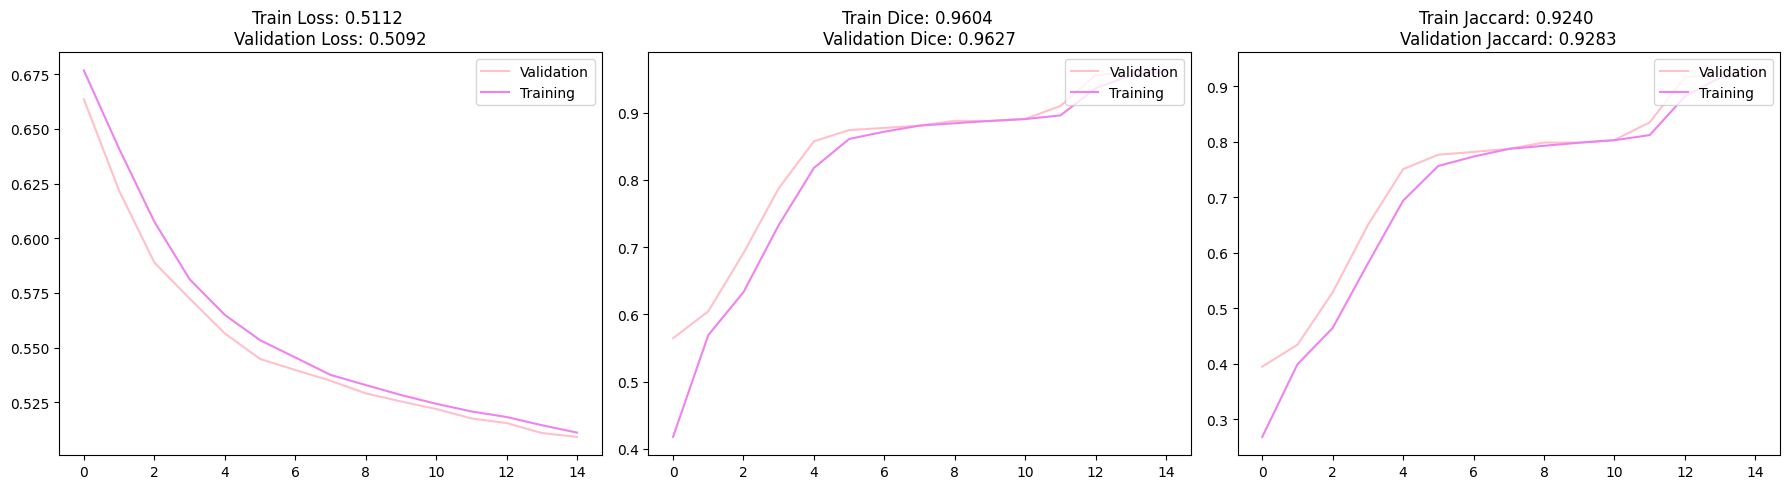

train epoch 16/50: 100%|██████████| 38/38 [00:28<00:00,  1.33it/s]


Loss: 0.5084 | Dice: 0.9643 | IoU: 0.9312


val epoch 16/50: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


Loss: 0.5066 | Dice: 0.9651 | IoU: 0.9328


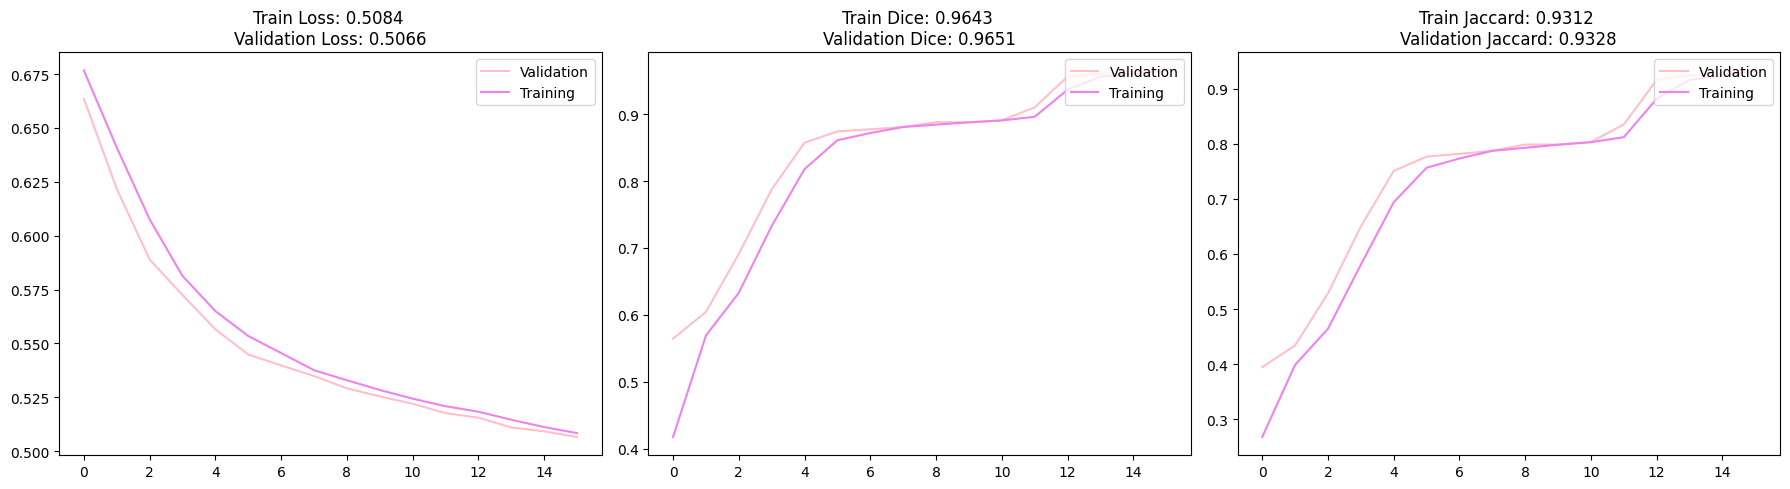

train epoch 17/50: 100%|██████████| 38/38 [00:28<00:00,  1.33it/s]


Loss: 0.5055 | Dice: 0.9663 | IoU: 0.9350


val epoch 17/50: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]


Loss: 0.5048 | Dice: 0.9660 | IoU: 0.9344


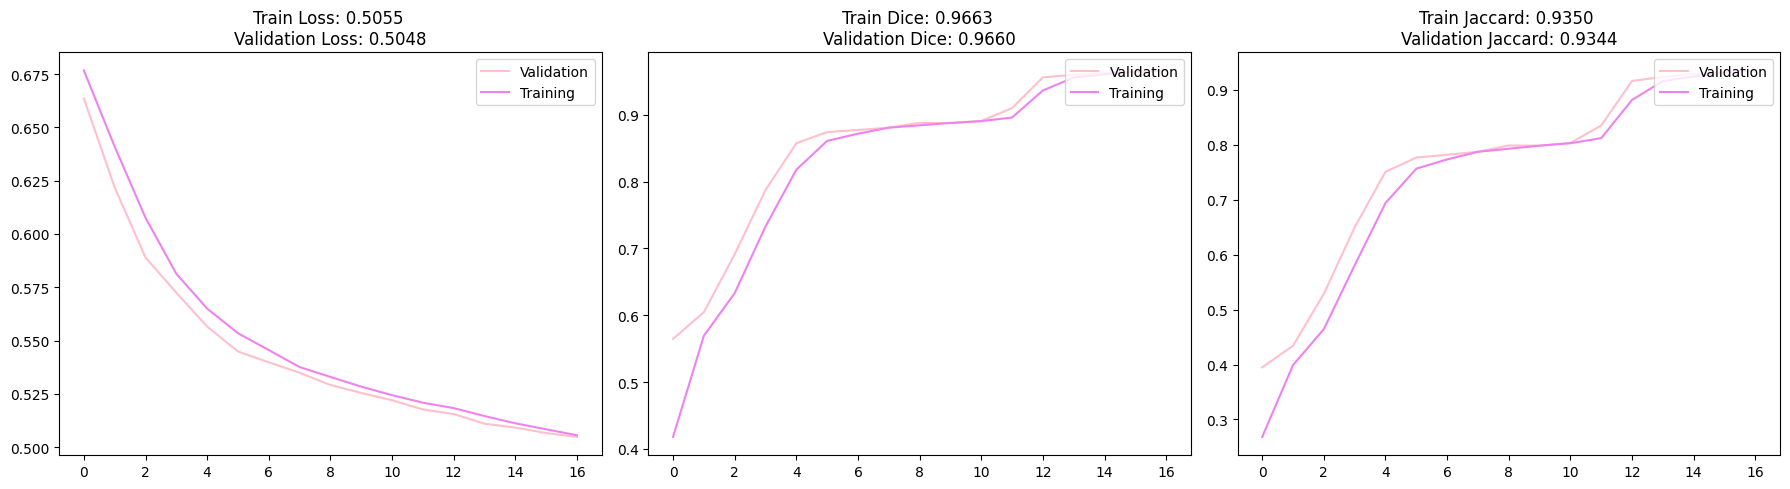

train epoch 18/50: 100%|██████████| 38/38 [00:28<00:00,  1.32it/s]


Loss: 0.5025 | Dice: 0.9674 | IoU: 0.9371


val epoch 18/50: 100%|██████████| 5/5 [00:01<00:00,  2.85it/s]


Loss: 0.5003 | Dice: 0.9694 | IoU: 0.9408


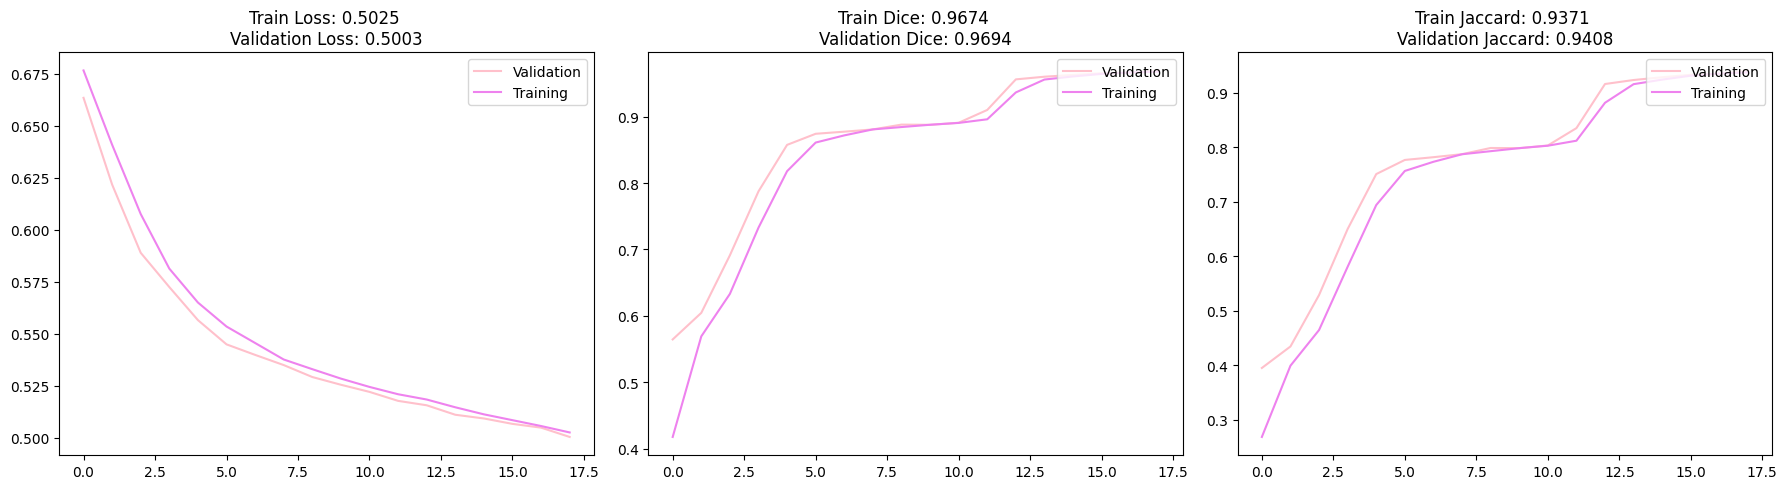

train epoch 19/50: 100%|██████████| 38/38 [00:28<00:00,  1.32it/s]


Loss: 0.4997 | Dice: 0.9693 | IoU: 0.9406


val epoch 19/50: 100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


Loss: 0.4993 | Dice: 0.9691 | IoU: 0.9402


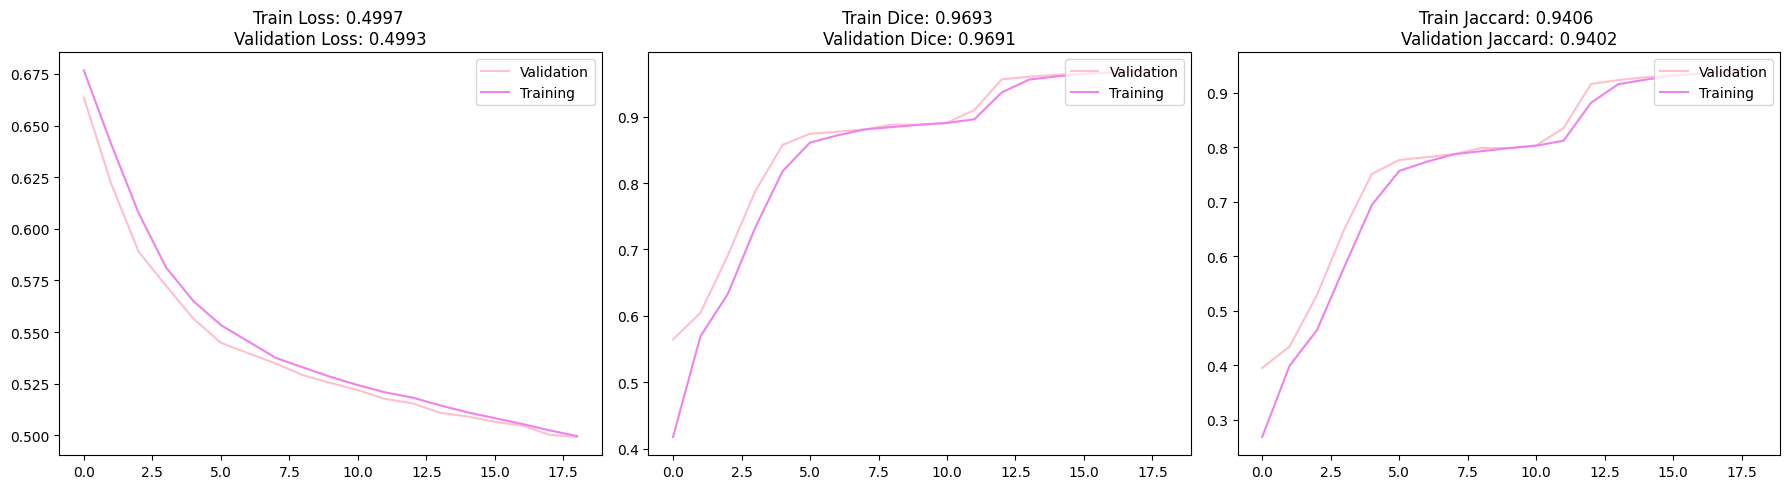

train epoch 20/50: 100%|██████████| 38/38 [00:28<00:00,  1.34it/s]


Loss: 0.4968 | Dice: 0.9713 | IoU: 0.9444


val epoch 20/50: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


Loss: 0.4973 | Dice: 0.9701 | IoU: 0.9422


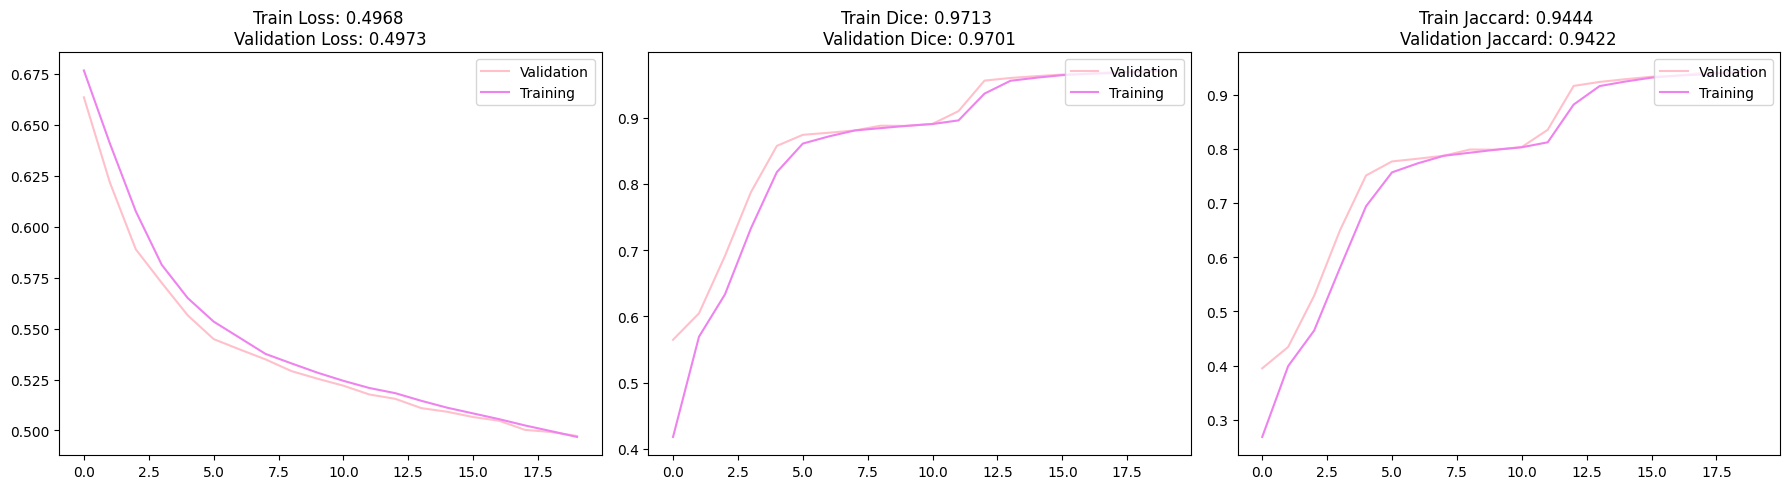

train epoch 21/50: 100%|██████████| 38/38 [00:29<00:00,  1.29it/s]


Loss: 0.4947 | Dice: 0.9728 | IoU: 0.9472


val epoch 21/50: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


Loss: 0.4948 | Dice: 0.9695 | IoU: 0.9411


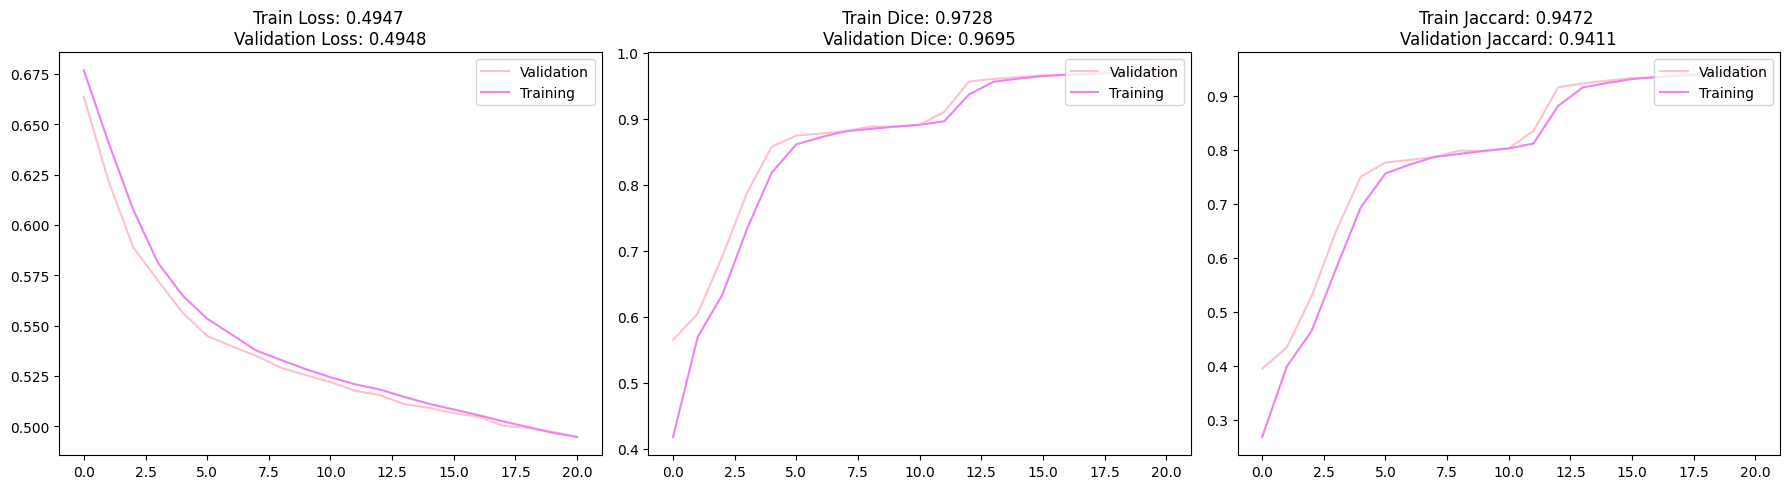

train epoch 22/50: 100%|██████████| 38/38 [00:28<00:00,  1.33it/s]


Loss: 0.4924 | Dice: 0.9731 | IoU: 0.9477


val epoch 22/50: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


Loss: 0.4906 | Dice: 0.9751 | IoU: 0.9516


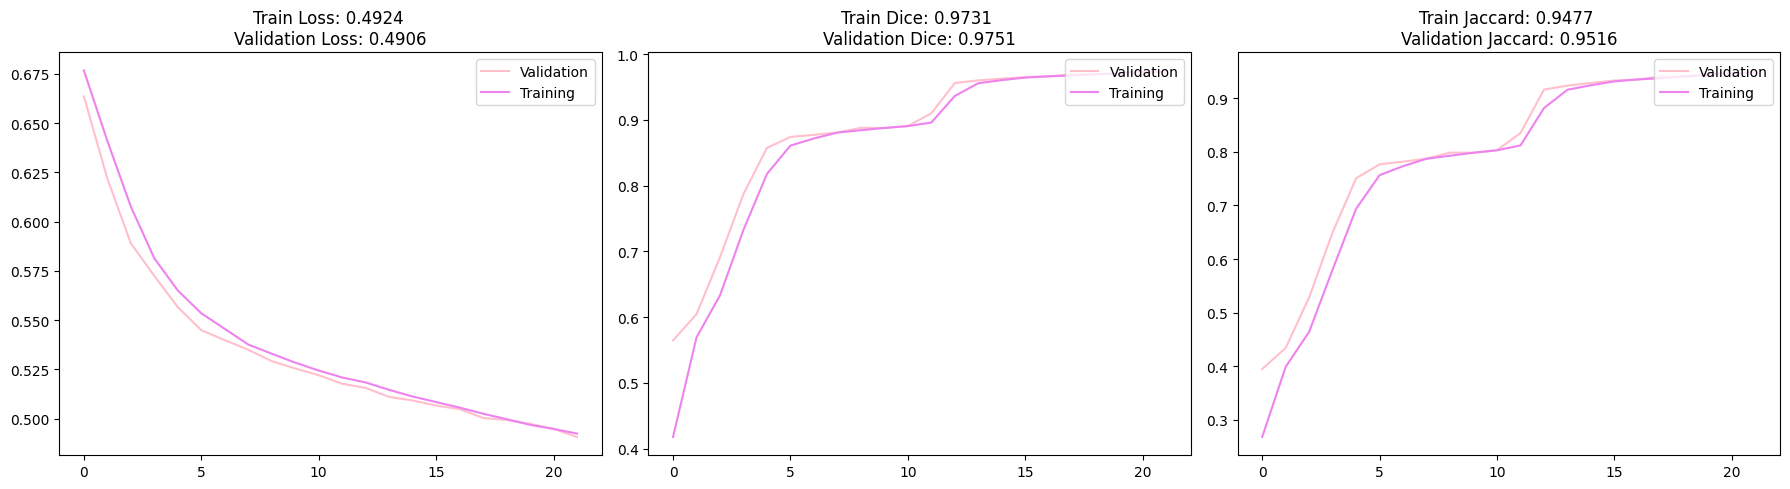

train epoch 23/50: 100%|██████████| 38/38 [00:28<00:00,  1.33it/s]


Loss: 0.4889 | Dice: 0.9754 | IoU: 0.9520


val epoch 23/50: 100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


Loss: 0.4870 | Dice: 0.9763 | IoU: 0.9539


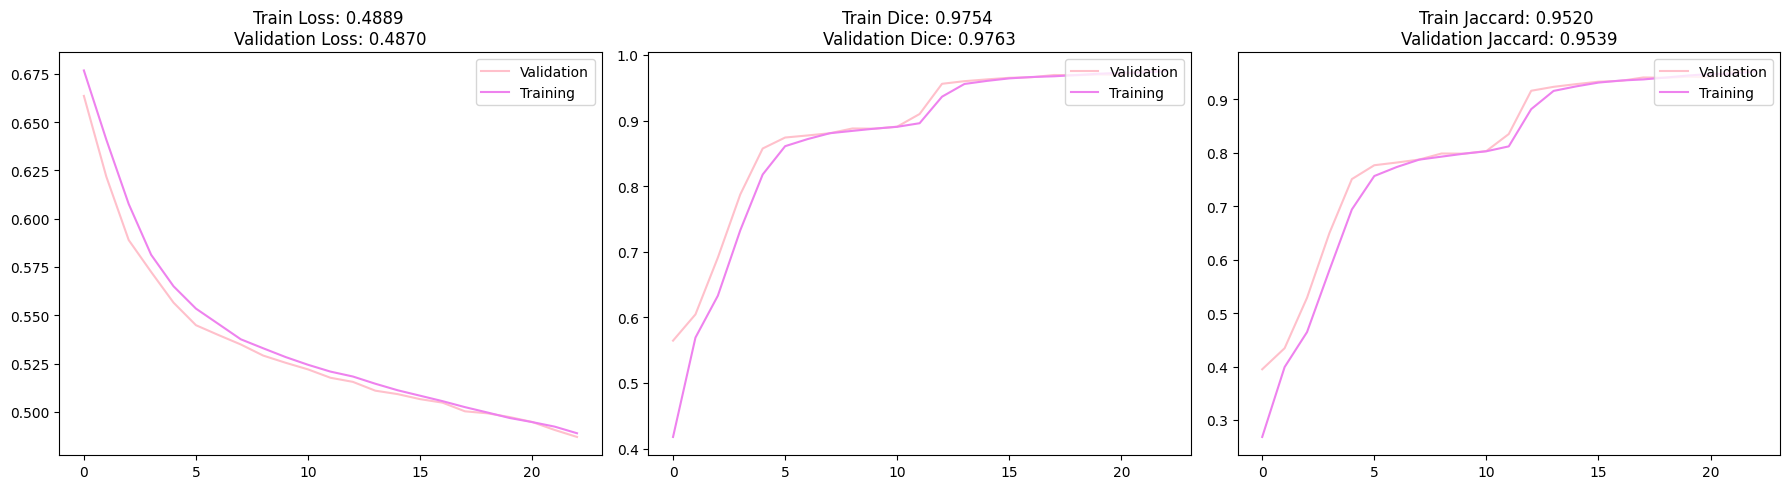

train epoch 24/50: 100%|██████████| 38/38 [00:29<00:00,  1.29it/s]


Loss: 0.4857 | Dice: 0.9769 | IoU: 0.9549


val epoch 24/50: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


Loss: 0.4856 | Dice: 0.9756 | IoU: 0.9525


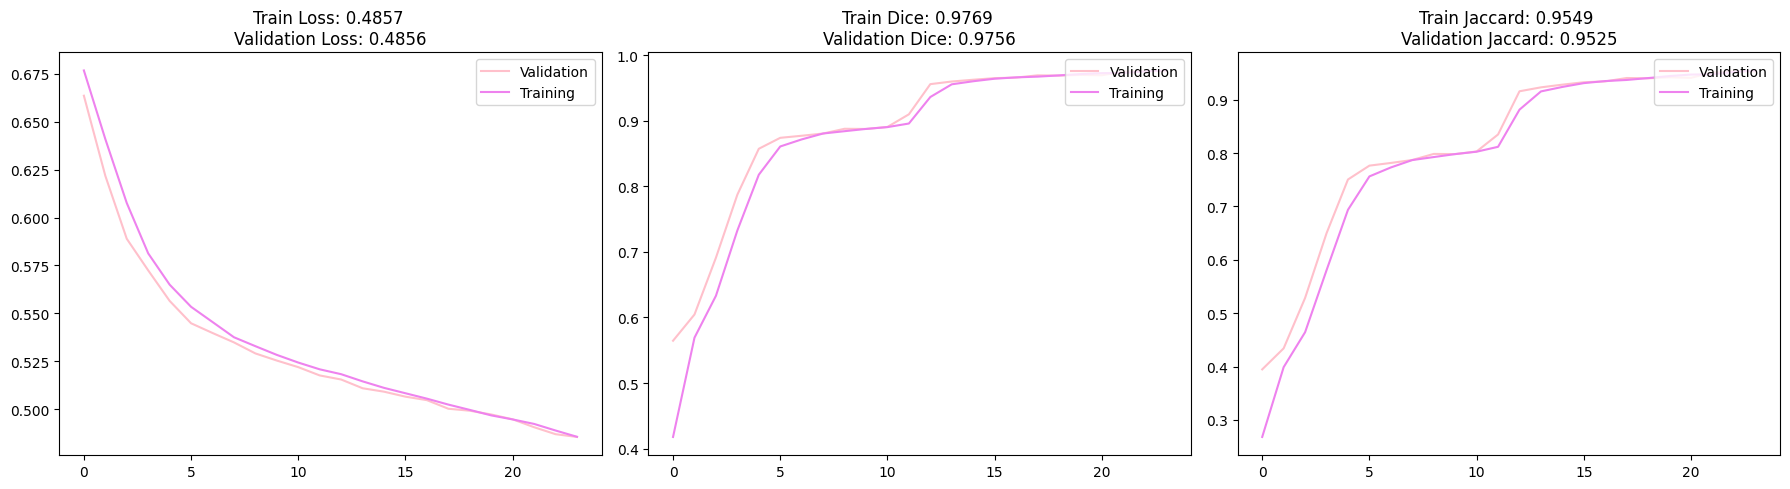

train epoch 25/50: 100%|██████████| 38/38 [00:29<00:00,  1.30it/s]


Loss: 0.4826 | Dice: 0.9775 | IoU: 0.9560


val epoch 25/50: 100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Loss: 0.4839 | Dice: 0.9736 | IoU: 0.9487


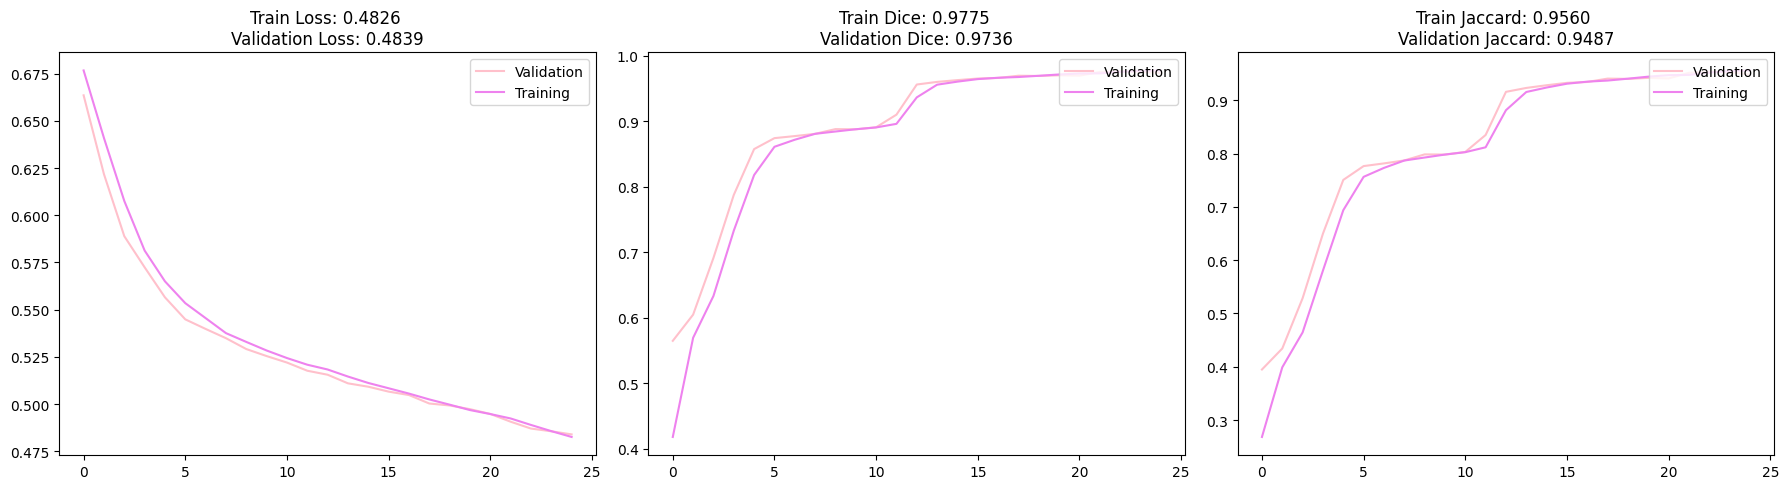

train epoch 26/50: 100%|██████████| 38/38 [00:29<00:00,  1.30it/s]


Loss: 0.4800 | Dice: 0.9789 | IoU: 0.9588


val epoch 26/50: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


Loss: 0.4801 | Dice: 0.9750 | IoU: 0.9515


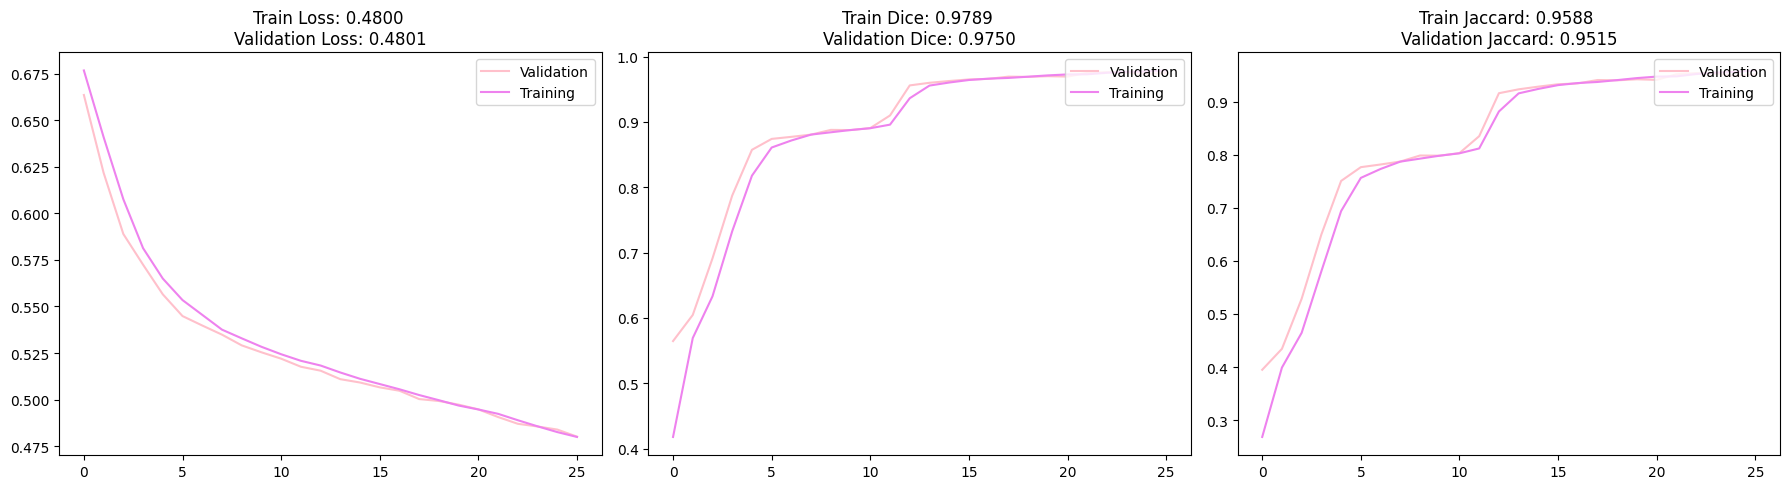

train epoch 27/50: 100%|██████████| 38/38 [00:29<00:00,  1.30it/s]


Loss: 0.4779 | Dice: 0.9799 | IoU: 0.9606


val epoch 27/50: 100%|██████████| 5/5 [00:01<00:00,  2.82it/s]


Loss: 0.4768 | Dice: 0.9813 | IoU: 0.9634


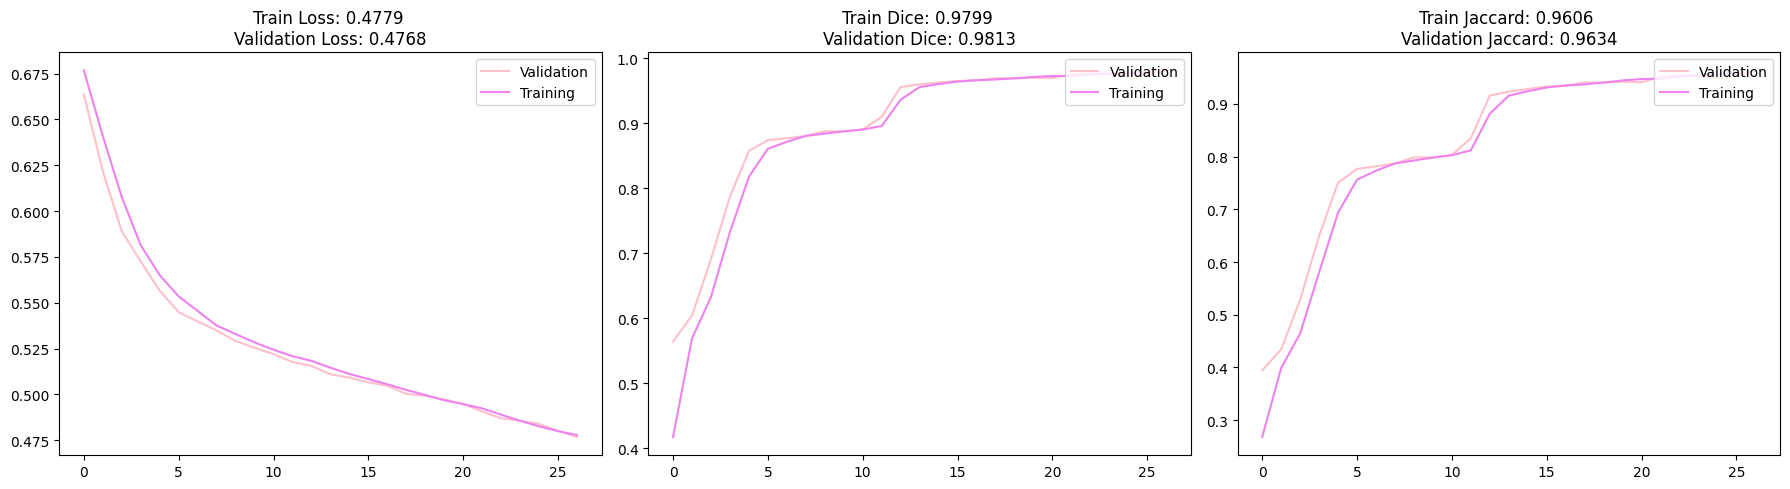

train epoch 28/50: 100%|██████████| 38/38 [00:29<00:00,  1.30it/s]


Loss: 0.4732 | Dice: 0.9835 | IoU: 0.9675


val epoch 28/50: 100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


Loss: 0.4734 | Dice: 0.9821 | IoU: 0.9649


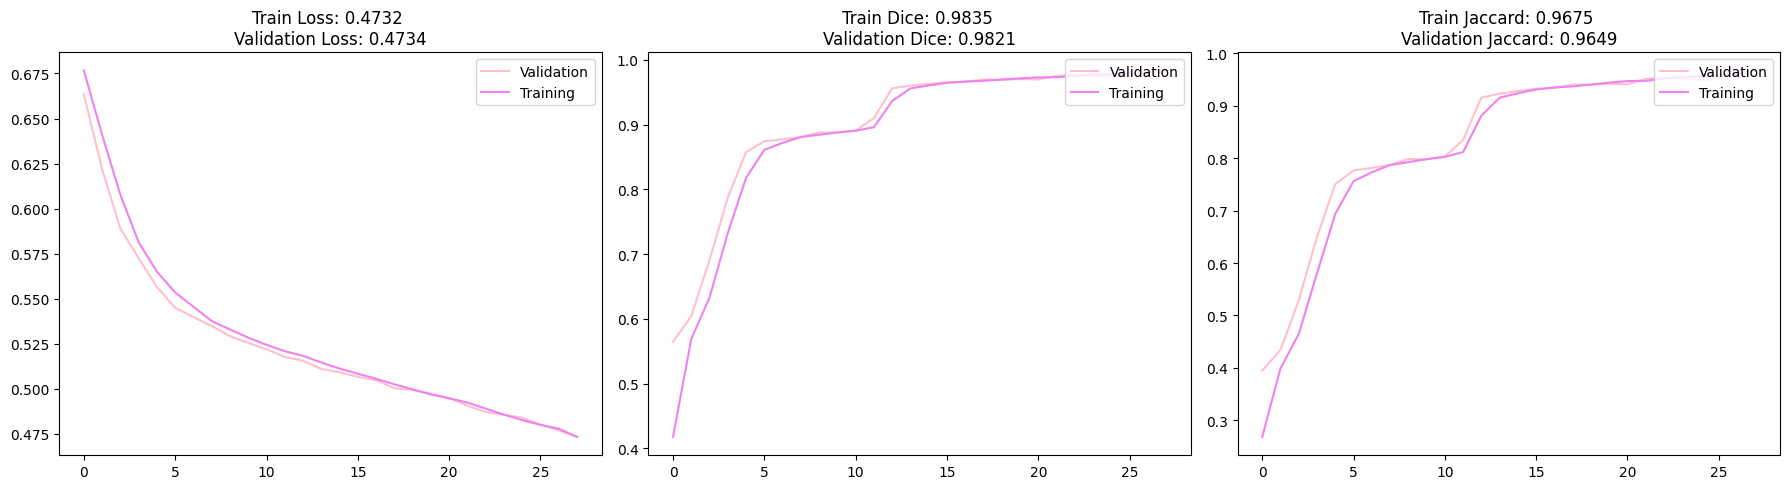

train epoch 29/50: 100%|██████████| 38/38 [00:28<00:00,  1.33it/s]


Loss: 0.4689 | Dice: 0.9845 | IoU: 0.9696


val epoch 29/50: 100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


Loss: 0.4673 | Dice: 0.9829 | IoU: 0.9665


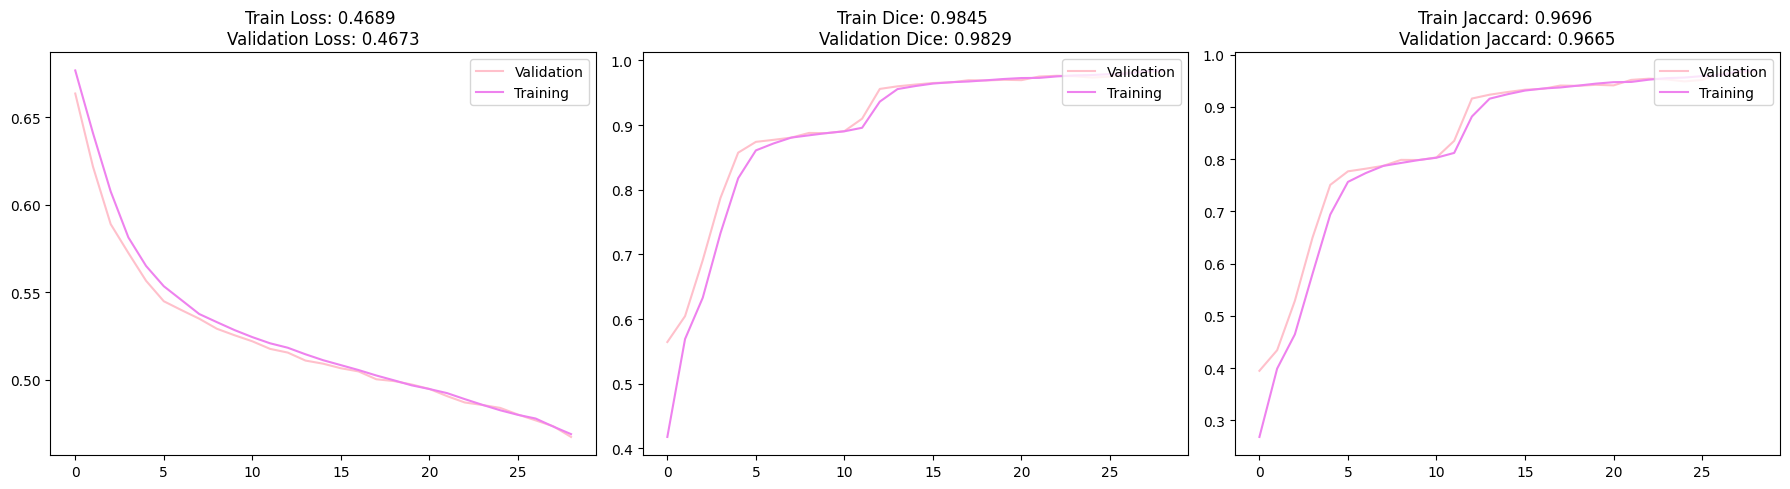

train epoch 30/50: 100%|██████████| 38/38 [00:28<00:00,  1.33it/s]


Loss: 0.4653 | Dice: 0.9849 | IoU: 0.9704


val epoch 30/50: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


Loss: 0.4655 | Dice: 0.9832 | IoU: 0.9671


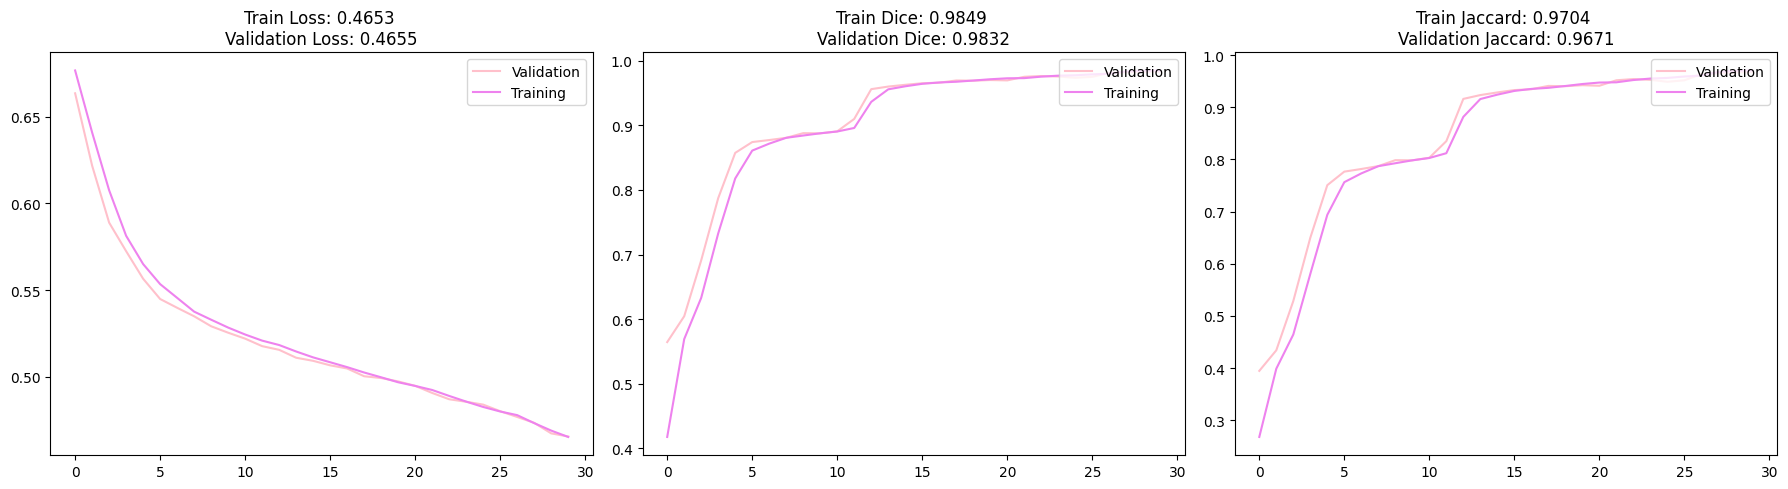

train epoch 31/50: 100%|██████████| 38/38 [00:29<00:00,  1.29it/s]


Loss: 0.4614 | Dice: 0.9855 | IoU: 0.9715


val epoch 31/50: 100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


Loss: 0.4627 | Dice: 0.9833 | IoU: 0.9672


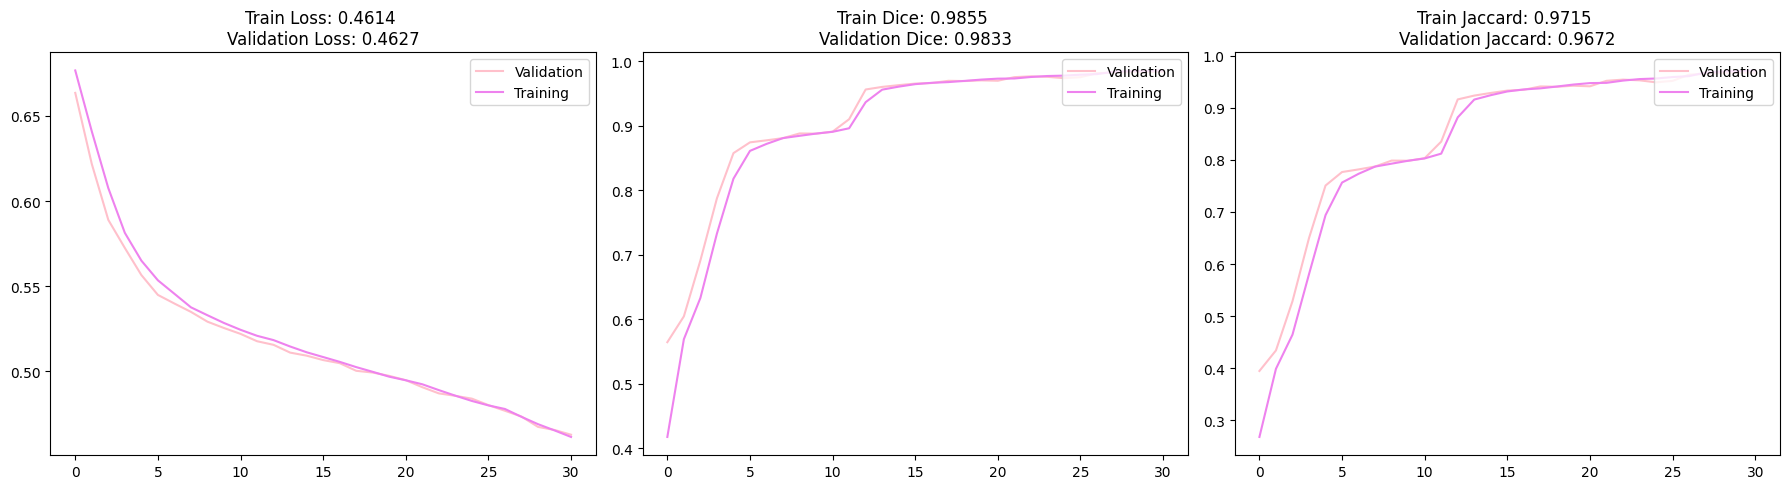

train epoch 32/50: 100%|██████████| 38/38 [00:29<00:00,  1.30it/s]


Loss: 0.4582 | Dice: 0.9859 | IoU: 0.9722


val epoch 32/50: 100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


Loss: 0.4602 | Dice: 0.9833 | IoU: 0.9674


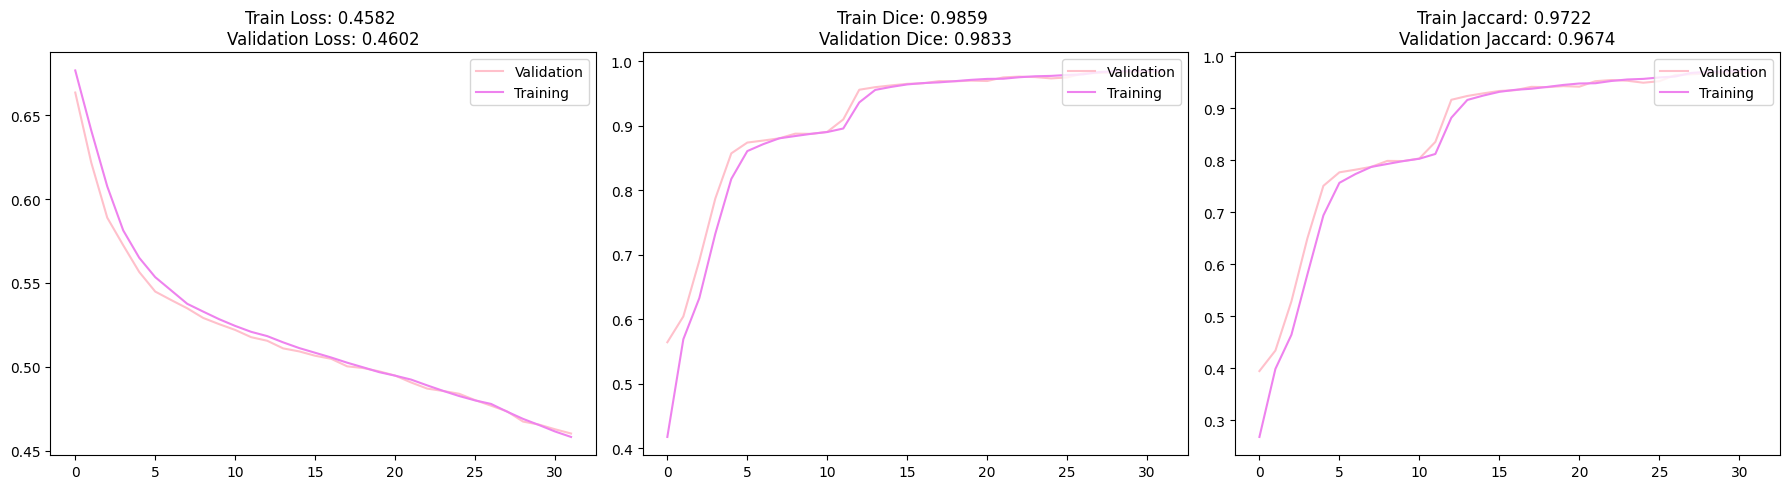

train epoch 33/50: 100%|██████████| 38/38 [00:28<00:00,  1.31it/s]


Loss: 0.4546 | Dice: 0.9863 | IoU: 0.9731


val epoch 33/50:  80%|████████  | 4/5 [00:01<00:00,  2.52it/s]

In [ ]:
%%time
trainer.run()

In [ ]:
def coef_metric_per_classes(probabilities, truth, threshold=0.5, eps=1e-9, classes=['WT', 'TC', 'ET', 'BG'], metric='dice'):
    scores = {key: [] for key in classes}
    predictions = (probabilities >= threshold).astype(np.float32)

    for i in range(probabilities.shape[0]):
        for class_, class_name in enumerate(classes):
            prediction = predictions[i, class_]
            truth_ = truth[i, class_]

            if metric == 'dice':
                intersection = 2.0 * np.sum(truth_ * prediction)
                union = np.sum(truth_) + np.sum(prediction)
            elif metric == 'jaccard':
                intersection = np.sum(prediction * truth_)
                union = np.sum(prediction) + np.sum(truth_) - intersection + eps
            else:
                raise ValueError("Unsupported metric. Use 'dice' or 'jaccard'.")

            if np.sum(truth_) == 0 and np.sum(prediction) == 0:
                scores[class_name].append(1.0)
            else:
                scores[class_name].append((intersection + eps) / (union + eps))

    return scores

def compute_scores_per_classes(model, dataloader, classes):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dice_scores_per_classes = {key: list() for key in classes}
    iou_scores_per_classes = {key: list() for key in classes}
    loss_per_batch = []

    criterion = bce_dice_loss  # Use the appropriate loss function

    with torch.no_grad():
        for i, (imgs, targets) in enumerate(dataloader):
            imgs, targets = imgs.to(device), targets.to(device)
            logits = model(imgs.float())

            # Compute loss
            loss = criterion(logits, targets, alpha=0.5, beta=0.5)
            loss_per_batch.append(loss.item())

            logits = logits.detach().cpu().numpy()
            targets = targets.detach().cpu().numpy()

            dice_scores = coef_metric_per_classes(logits, targets, metric='dice')
            iou_scores = coef_metric_per_classes(logits, targets, metric='jaccard')

            for key in dice_scores.keys():
                dice_scores_per_classes[key].extend(dice_scores[key])

            for key in iou_scores.keys():
                iou_scores_per_classes[key].extend(iou_scores[key])

    average_loss = sum(loss_per_batch) / len(loss_per_batch)

    return average_loss, dice_scores_per_classes, iou_scores_per_classes

In [ ]:
model.eval();

In [ ]:
average_test_loss, dice_scores_per_classes, iou_scores_per_classes = compute_scores_per_classes(model, test_dl, ['WT', 'TC', 'ET', 'BG'])

print(f"Average Test Loss: {average_test_loss:.4f}\n")

for key in dice_scores_per_classes.keys():
    print(f"Average Test Dice ({key}): {np.mean(dice_scores_per_classes[key]):.4f}")
print("\t")
for key in iou_scores_per_classes.keys():
    print(f"Average Test Jaccard ({key}): {np.mean(iou_scores_per_classes[key]):.4f}")

In [ ]:
# Plot the Dice scores
plt.figure(figsize=(10, 5))
for key in dice_scores_per_classes.keys():
    plt.plot(dice_scores_per_classes[key], label=f'{key} Dice')
plt.title('Dice Scores per Class')
plt.xlabel('Dirs')
plt.ylabel('Dice Score')
plt.legend()
plt.show()

# Plot the Jaccard scores
plt.figure(figsize=(10, 5))
for key in iou_scores_per_classes.keys():
    plt.plot(iou_scores_per_classes[key], label=f'{key} Jaccard')
plt.title('Jaccard Scores per Class')
plt.xlabel('Dirs')
plt.ylabel('Jaccard Score')
plt.legend()
plt.show()


In [ ]:
dice_df = pd.DataFrame(dice_scores_per_classes)
dice_df.columns = ['WT dice', 'TC dice', 'ET dice', 'BG dice']

iou_df = pd.DataFrame(iou_scores_per_classes)
iou_df.columns = ['WT jaccard', 'TC jaccard', 'ET jaccard', 'BG jaccard']
val_metics_df = pd.concat([dice_df, iou_df], axis=1, sort=True)
val_metics_df = val_metics_df.loc[:, ['WT dice', 'WT jaccard',
                                      'TC dice', 'TC jaccard',
                                      'ET dice', 'ET jaccard',
                                      'BG dice', 'BG jaccard']]
val_metics_df.sample(5)

In [ ]:
## Prosječne vrijednosti Dice i Jaccard koeficijenata za svaku od klasa na validacijskom skupu

unique_categories = val_metics_df.mean().index
palette = sns.color_palette("husl", len(unique_categories))

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=val_metics_df.mean().index, y=val_metics_df.mean(), hue=val_metics_df.mean().index, palette=palette, ax=ax, legend=False)

ax.set_xticks(range(len(val_metics_df.mean().index)))
ax.set_xticklabels(val_metics_df.columns, fontsize=14, rotation=15)

ax.set_title("Dice and Jaccard Coefficients from Validation", fontsize=20)

for idx, p in enumerate(ax.patches):
    percentage = '{:.1f}%'.format(100 * val_metics_df.mean().values[idx])
    x = p.get_x() + p.get_width() / 2 - 0.15
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y), fontsize=15, fontweight="bold")

fig.savefig("result1.png", format="png", pad_inches=0.2, transparent=False, bbox_inches='tight')

plt.show()

In [ ]:
def show_results(model, test_dl):
    dl_iter = iter(test_dl)
    images, masks = next(dl_iter)

    images = images.to(device)
    masks = masks.to(device)
    outputs = model(images.float())

    preds = torch.argmax(outputs, dim=1)
    masks = torch.argmax(masks, dim=1)

    plt.figure(figsize=(25, 65))

    for i in range(3):
        for j in range(len(modality_types)):
            plt.subplot(16, 6, 6 * i + j + 1)
            plt.axis('off')
            plt.title(modality_types[j])
            plt.imshow(images[i][j].cpu(), cmap='gray')

        # show True Mask
        plt.subplot(16, 6, 6 * i + 5)
        plt.title('True Mask')
        plt.grid()
        plt.imshow(255 - masks[i].cpu(), cmap='viridis')

        # show Predicted Mask
        plt.subplot(16, 6, 6 * i + 6)
        plt.title('Predicted Mask')
        plt.grid()
        plt.imshow(255 - preds[i].cpu(), cmap='viridis')

    plt.show()

show_results(model, test_dl)